In [ ]:
import sys, os, re
import copy, glob, yaml, json, math
import importlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d, gaussian_filter1d, percentile_filter
from scipy.stats import binned_statistic, zscore
import scipy.stats as stats
import suite2p 
from suite2p.extraction import dcnv
import pandas as pd
import glob 
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import wesanderson
from cycler import cycler
import itertools
pio.renderers.default = "browser"

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append(os.path.abspath(os.path.join('..', 'preprocessing')))
sys.path.append(os.path.abspath(os.path.join('..', 'cellTV')))

import preprocessing.parse_session_functions_cohort2 as parse_session_functions
import neural_analysis_helpers
import alternation_analysis_helpers as alternation
import cellTV.cellTV_functions_cohort2 as cellTV

importlib.reload(parse_session_functions)
importlib.reload(neural_analysis_helpers)
importlib.reload(alternation)
importlib.reload(cellTV)

import palettes
tm_palette = palettes.met_brew('Tam',n=123, brew_type="continuous")
tm_palette = tm_palette[::-1]
color_scheme = wesanderson.film_palette('Darjeeling Limited',palette=0)
custom_cycler = cycler(color=color_scheme)
hfs_palette = np.array(palettes.met_brew('Austria',n=8, brew_type="continuous"))

#### Load data

Working on T5
DF_F0 file found. Loading...
(624, 78437)
Training and Imaging
Total rewards considered here:  101
Total rewards not considered here:  9
Total assistant and manual rewards:  9
Reward time lag from lm entry:  29.0
Total licks considered here:  2694


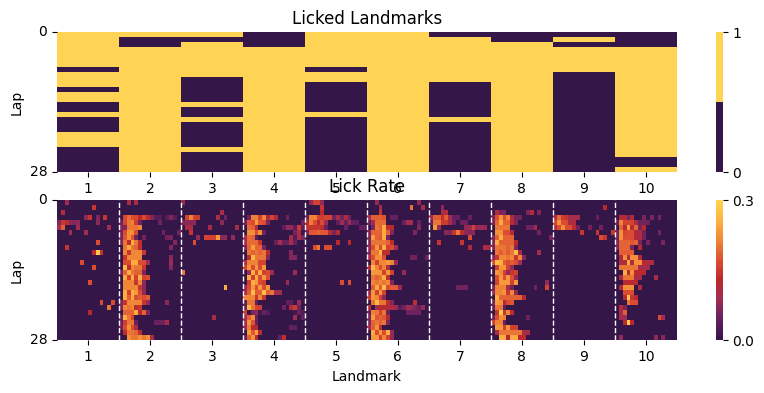

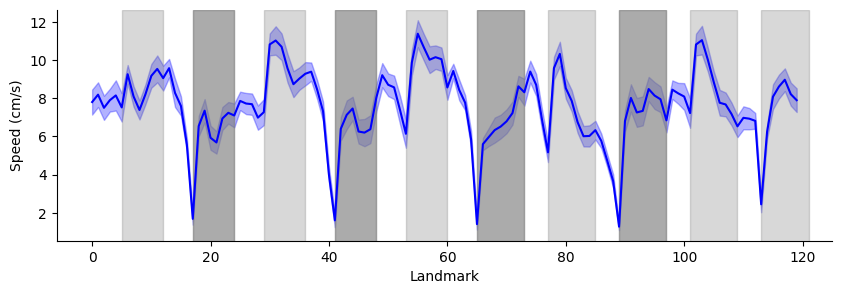

Number of laps =  1


In [ ]:
# Define relevant directories and session specific info
base_path = Path('/Volumes/mrsic_flogel/public/projects/AtApSuKuSaRe_20250129_HFScohort2')
mouse = 'TAA0000066'
date = '20250315'
sess = 'ses-011_date-20250315_protocol-t5'
sess_data_path = base_path / mouse / sess
funcimg_path = 'funcimg/Session'

protocol_num = int(re.search(r'protocol-t(\d+)', sess).group(1))
print(f'Working on T{protocol_num}')
ABCD_goals = [1,2,3,4]
funcimg_frame_rate = 45

# Load data 
save_path, dF, session = neural_analysis_helpers.load_dF_session_data(base_path, mouse, stage='-t5')

behav_path = parse_session_functions.find_base_path(mouse, date)
VR_data = parse_session_functions.load_session(str(behav_path))
behav_path_npz = parse_session_functions.find_base_path_npz(mouse, date)
nidaq_data = parse_session_functions.load_session_npz(str(behav_path_npz))



In [ ]:
# Is there a threshold to define change in behaviour state? 
# NOTE This is just exploratory for now. No threshold is defined. 
keys = sorted(session['lm_lick_rate'].keys())  
first_keys = set(k[0] for k in keys)

num_lms_considered = int(np.round((len(session['all_landmarks']) // 10) * 10))
num_laps = int(num_lms_considered / session['num_landmakrs'])

if len(first_keys) == 1:
    lm_lick_rate = [[] for _ in range(num_laps)]
    for lm_idx in range(num_lms_considered):
        lap = lm_idx // session['num_landmakrs']
        key = (0, lm_idx)
        if key in session['lm_lick_rate']:
            rate = session['lm_lick_rate'][key]
            lm_lick_rate[lap].extend(rate)
else:
    lm_lick_rate = [[] for _ in range(num_laps)]
    for i in range(num_laps):
        for lm_idx in range(num_lms_considered):
            lap = lm_idx // session['num_landmakrs']
            key = (i, lm_idx)
            if key in session['lm_lick_rate']:
                rate = session['lm_lick_rate'][key]
                lm_lick_rate[lap].extend(rate)

lm_lick_rate = np.array(lm_lick_rate)

test_lm_lick_rate = np.mean(lm_lick_rate[:, -16:], axis=1)
filtered_test_lm_lick_rate = gaussian_filter1d(test_lm_lick_rate, sigma=1)

plt.figure(figsize=(3,3))
plt.plot(test_lm_lick_rate, linewidth=3, label='avg')
plt.plot(filtered_test_lm_lick_rate, linewidth=3, label='smoothed avg')
plt.xlabel('Landmark')
plt.ylabel('Lick Rate')
plt.legend(loc='upper right')

Out of the 624 ROIs, 517 are classified as neurons, and 319 have time-varying Ca2+ signals and will be considered here.


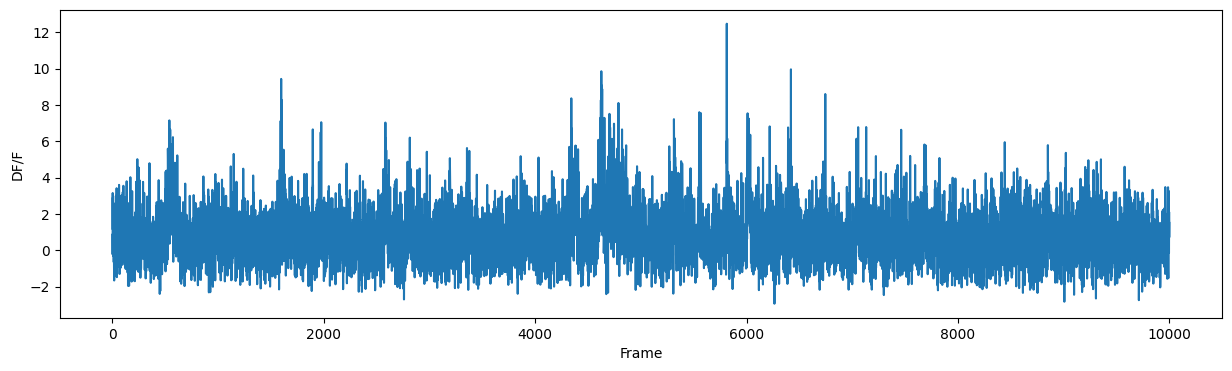

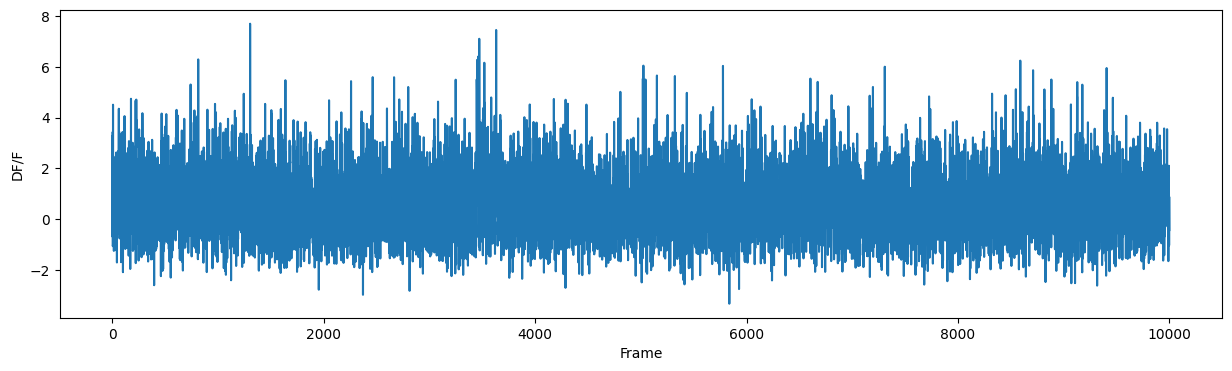

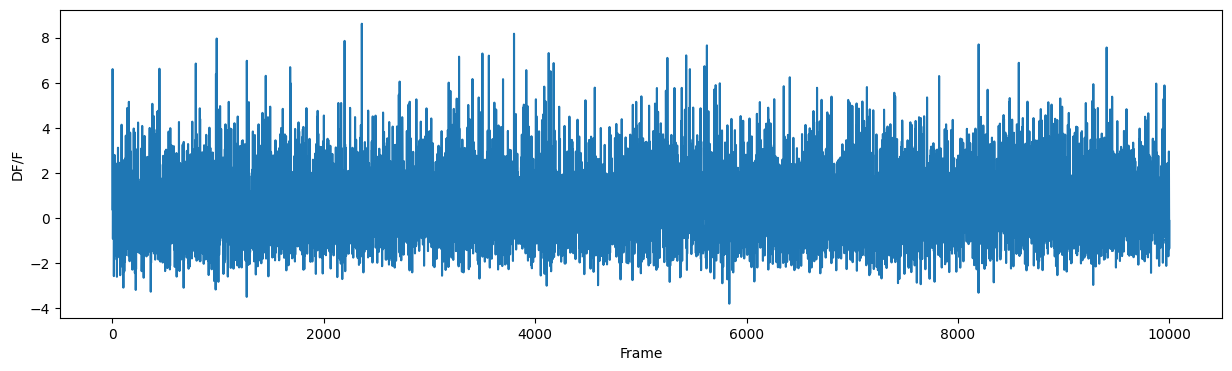

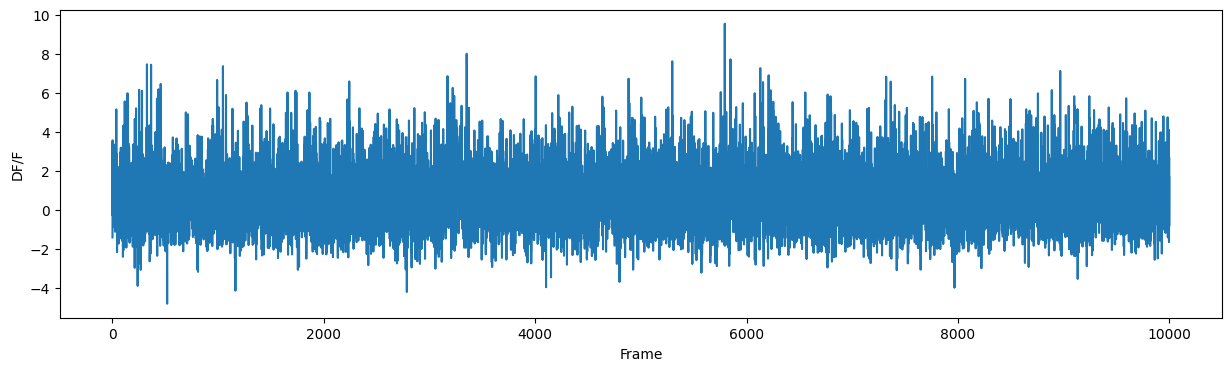

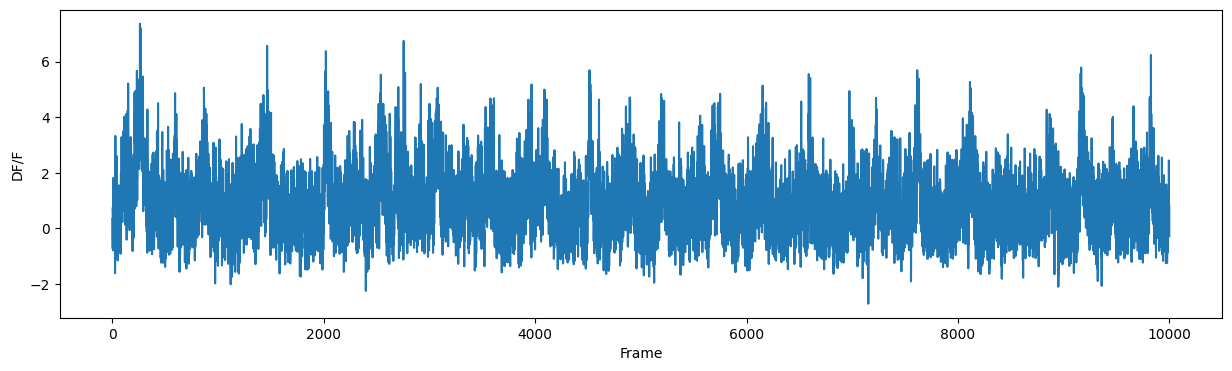

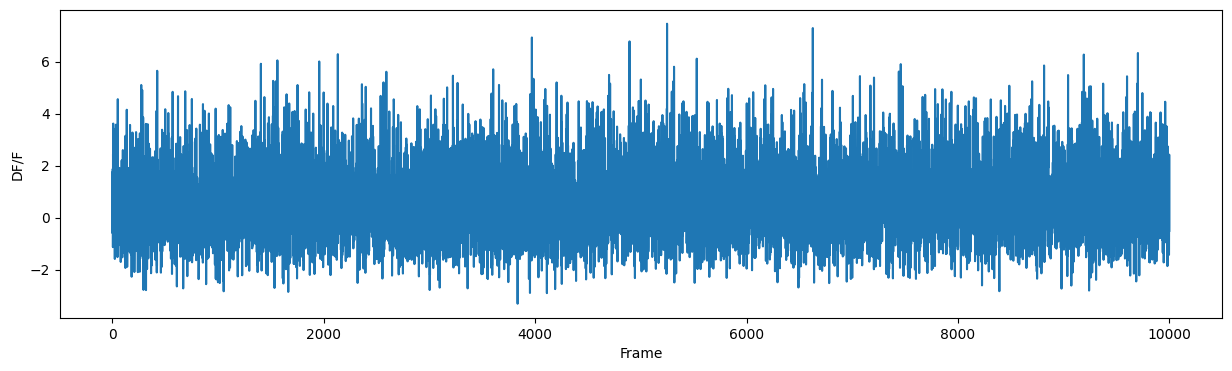

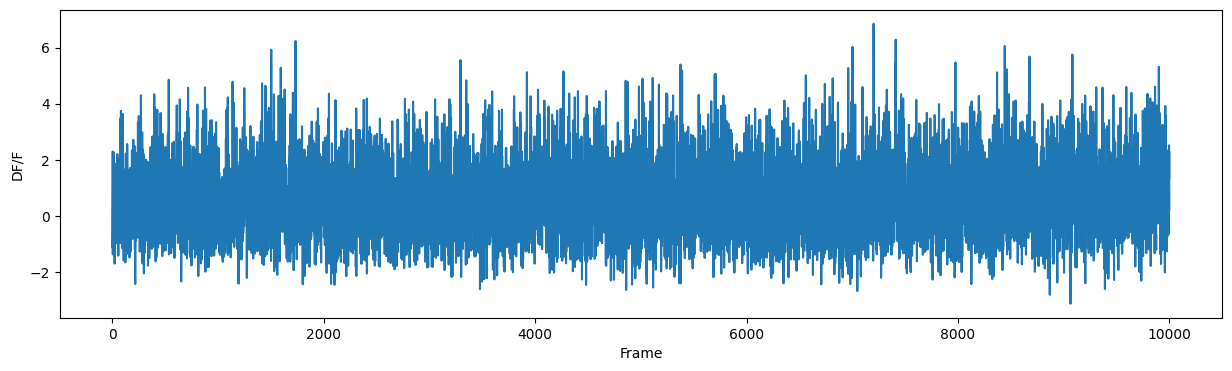

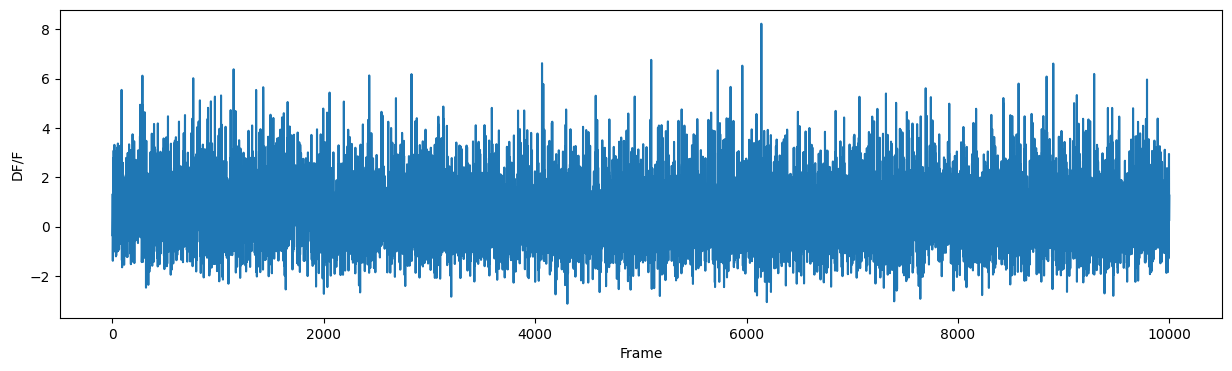

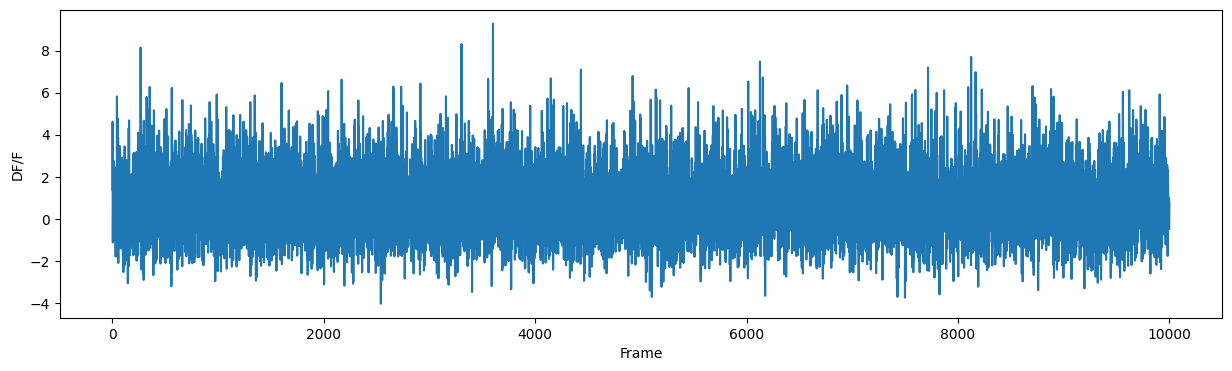

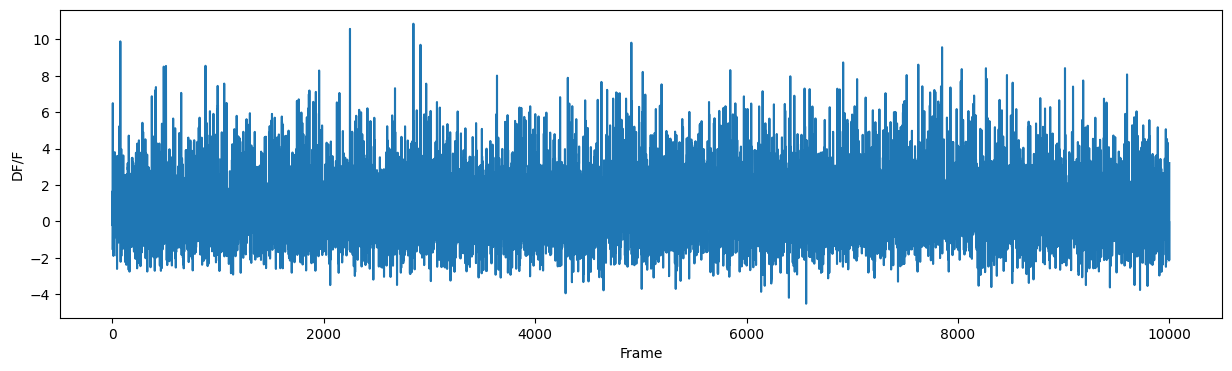

In [ ]:
# Look at distribution of DF/F to select valid neurons

# Load suite2p outputs
ops = np.load(os.path.join(sess_data_path, funcimg_path, 'suite2p/plane0/ops.npy'), allow_pickle=True).item()
iscell = np.load(os.path.join(sess_data_path, funcimg_path, 'suite2p/plane0/iscell.npy'))[:,0]

neurons = np.where(iscell == 1)[0]  # select ROIs that are classified as neurons
num_neurons = len(neurons)

# Subselect neurons
neurons_considered = []

for n in neurons: 
    deltas = dF[n,:] - np.mean(dF[n,:])
    # plt.hist(deltas, bins=100)
    skew = stats.skew(deltas)

    if np.abs(skew) > 0.5:  # TODO: confirm 
        neurons_considered.append(n)

num_neurons_considered = len(neurons_considered)
print(f'Out of the {dF.shape[0]} ROIs, {num_neurons} are classified as neurons, and {num_neurons_considered} have time-varying Ca2+ signals and will be considered here.')

neurons_considered = np.array(neurons_considered)
np.savez(os.path.join(save_path, f'T{protocol_num}_neurons_considered.npz'), neurons_considered)

# Plot a few neurons
plot_range = 10000
xdata = np.arange(0, plot_range) 
for n in neurons_considered[0:10]:
    fig, ax = plt.subplots(1, 1, figsize=(15,4), sharey=True)
    ax.plot(xdata, dF[n,0:plot_range])
    ax.set_xlabel('Frame')
    ax.set_ylabel('DF/F')

#### Get reward psth and lick rate

26 neurons are tuned to reward.


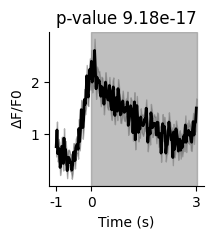

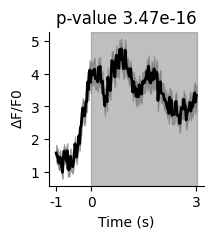

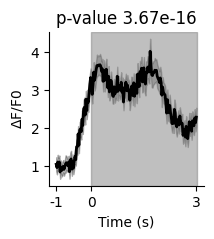

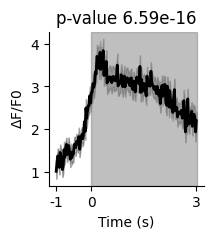

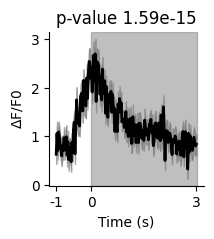

In [38]:
# Get reward PSTH
reward_psth, average_reward_psth = neural_analysis_helpers.get_psth(data=dF, neurons=neurons_considered, event_idx=session['reward_idx'], \
                                                            time_around=1)

# plot_avg_psth(average_psth=average_reward_psth, event='Reward', zscoring=True, time_around=1)

# Get reward-tuned neurons
significant_neurons_reward, stat, pvalue = neural_analysis_helpers.get_tuned_neurons(reward_psth, event='reward', time_around=1, plot_neurons=False)

# Plot the strongest responding cells 
pvalue = np.array(pvalue).flatten()
strongest_cell_idx = np.argsort(pvalue)
original_cell_idx = [cell for cell in strongest_cell_idx if cell in significant_neurons_reward]

# Plot reward PSTH for -1 to +3 s
long_reward_psth, long_average_reward_psth = neural_analysis_helpers.get_psth(data=dF, neurons=neurons_considered, event_idx=session['reward_idx'], \
                                                            time_around=(-1,3))

neural_analysis_helpers.plot_psth_single_neurons(long_reward_psth, long_average_reward_psth, neurons=original_cell_idx[0:5], time_around=(-1,3), num_neurons=5, pvalues=pvalue[strongest_cell_idx[0:5]], zscoring=False, avg_only=True)

Number of licks considered: 340


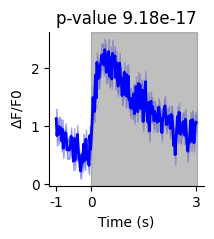

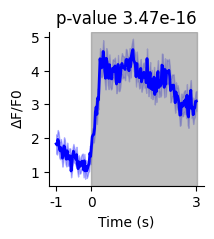

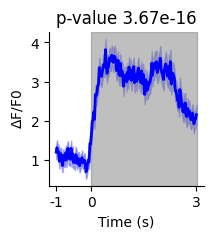

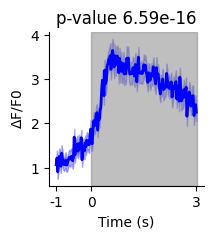

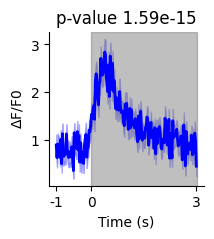

In [39]:

# Collect all licks 
licks = parse_session_functions.get_lick_types(session, VR_data, nidaq_data)

# Get first licks from each type
first_licks, all_first_licks = parse_session_functions.get_first_licks(session, VR_data, nidaq_data)

# Get lick PSTH for -1 to +3 s using only rewarded landmarks    
long_lick_psth, long_average_lick_psth = neural_analysis_helpers.get_psth(data=dF, neurons=neurons_considered, event_idx=first_licks[1], \
                                                            time_around=(-1,3))

neural_analysis_helpers.plot_psth_single_neurons(long_lick_psth, long_average_lick_psth, neurons=original_cell_idx[0:5], time_around=(-1,3), num_neurons=5, pvalues=pvalue[strongest_cell_idx[0:5]], zscoring=False, avg_only=True, color='blue')


In [ ]:
# Determine if events in the chosen time windows overlap with surrounding landmarks
parse_session_functions.get_events_in_surrounding_landmarks(session,
    events=first_licks[5],
    time_around=0.5,
    label="Reward anticipatory licks"
)

parse_session_functions.get_events_in_surrounding_landmarks(session,
    events=session['reward_idx'],
    time_around=1,
    label="Rewards"
)

parse_session_functions.get_events_in_surrounding_landmarks(session,
    events=first_licks[3],
    time_around=1,
    label="Non-goal licks"
)

parse_session_functions.get_events_in_surrounding_landmarks(session,
    events=session['nongoal_rew_idx'],
    time_around=1,
    label="Non-goal imaginary rewards"
)


Reward anticipatory licks: 28
0 1038 1082
2 3666 3710
10 31911 31955
26 73818 73862
Rewards: 101
100 78331 78421
Non-goal licks: 53
0 213 303
Non-goal imaginary rewards: 141
0 214.0 304.0


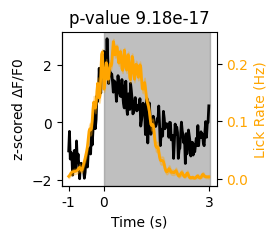

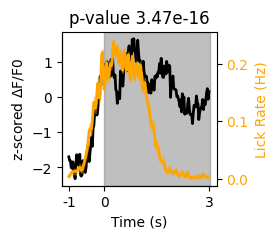

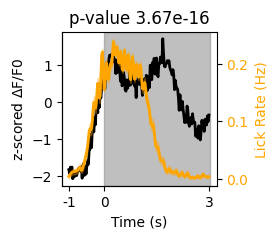

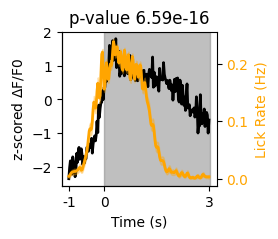

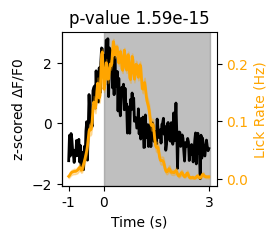

In [44]:
# Get lick rate for time window around rewards
event_lick_rate = parse_session_functions.get_event_lick_rate(session, nidaq_data, event_idx=session['reward_idx'], time_around=(-1,3))

neural_analysis_helpers.plot_psth_single_neurons(psth=long_reward_psth, average_psth=long_average_reward_psth, neurons=original_cell_idx[0:5], \
                         time_around=(-1, 3), num_neurons=5, avg_only=True, zscoring=True, \
                            event_lick_rate=event_lick_rate, pvalues=pvalue[strongest_cell_idx[0:5]], color=None)

#### Correlation sliding window with reward events

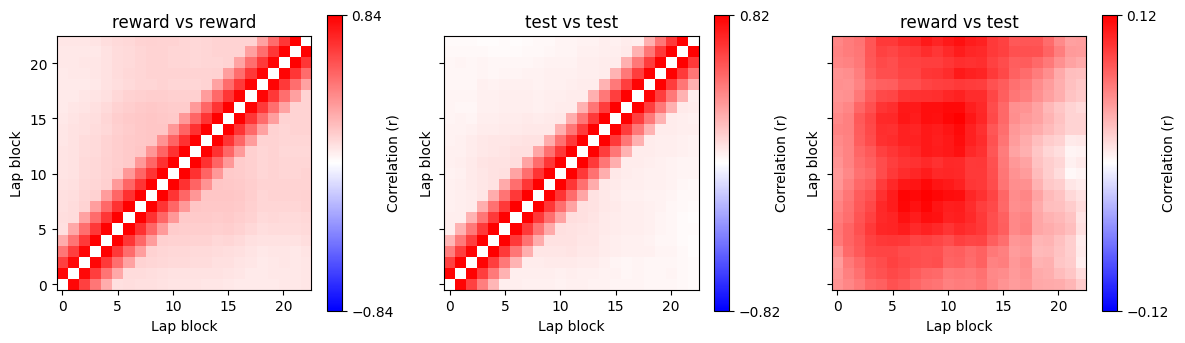

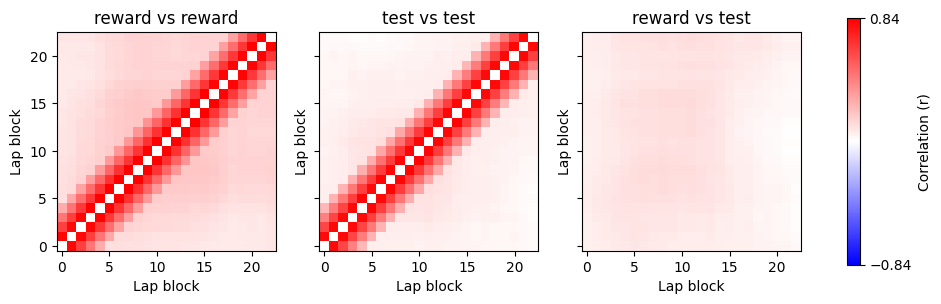

In [48]:
# Sliding window across T5 reward and test correlations
if protocol_num == 5 and mouse == 'TAA0000066':
    num_lms = len(session['all_lms'])
    num_lms_considered = np.round((num_lms // 10) * 10)
    ABCD_goals = [1,2,3,4]
    all_reward_idx = np.sort(np.concatenate([session['reward_idx'], session['miss_rew_idx'], session['nongoal_rew_idx'], session['test_rew_idx']]))

    landmark_psth, average_landmark_psth = neural_analysis_helpers.get_landmark_psth(data=dF, neurons=neurons_considered, event_idx=all_reward_idx[:num_lms_considered], \
                                                                num_landmarks=session['num_landmarks'], time_around=1)
         
    window_size = 5     # laps 
    
    # Get rolling reward avg
    rew_idx = {}    
    for g, goal in enumerate(ABCD_goals):
        # rew_idx[goal] = np.array([idx for idx in session['rewarded_landmarks'] \
        #                         if session['all_lms'][idx] == session['goal_landmark_id'][goal-1]])
        rew_idx[goal] = np.array([idx for idx in session['goals_idx'] \
                                if session['all_lms'][idx] == session['goal_landmark_id'][goal-1]])
        
        num_windows = len(rew_idx[goal]) 

    # TODO: fix window size?
    # psths_considered = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 
    rolling_avg_reward_psth = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 

    for i in range(num_windows-window_size):
        psths_considered = np.concatenate([landmark_psth[:, rew_idx[goal][i]:rew_idx[goal][i+window_size]:session['num_landmarks'], :] for goal in ABCD_goals], axis=1)
        # shape: num_neurons x window_size * num_goals x num_timebins

        rolling_avg_reward_psth[:, i, :] = np.mean(psths_considered, axis=1) 
        # shape: num_neurons x num_windows x num_timebins

    # Get rolling test avg
    # valid_test_indices = np.array([idx for idx in session['test_idx'] if (idx > session['rewarded_landmarks'][0] and idx < session['rewarded_landmarks'][-1]+3)])
    valid_test_indices = np.array([idx for idx in session['test_idx'] if (idx > session['goals_idx'][0] and idx < session['goals_idx'][-1]+3)])
    num_windows = int(len(valid_test_indices - window_size + 1))
    rolling_avg_test_psth = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 
    
    for i in range(num_windows-window_size):
        rolling_avg_test_psth[:, i, :] = np.mean(landmark_psth[:, valid_test_indices[i]:valid_test_indices[i+window_size]:num_landmarks, :], axis=1)

    # Get the pairwise correlations of rolling lap blocks
    conditions = ['reward', 'test']
    average_psths = [rolling_avg_reward_psth, rolling_avg_test_psth]

    # Get correlation matrix of average psths in rolling lap blocks
    similarity_neural_rew_test = neural_analysis_helpers.get_window_similarity_matrix(average_psths, conditions, population=False, zscoring=True, plot=True)

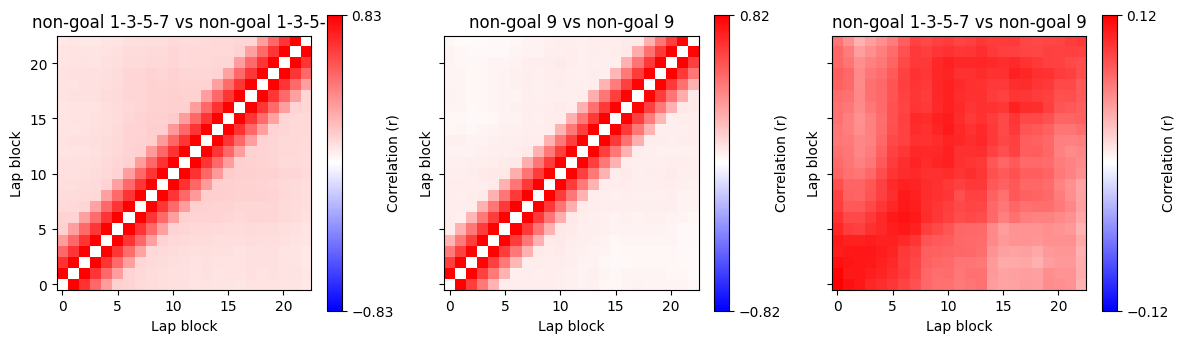

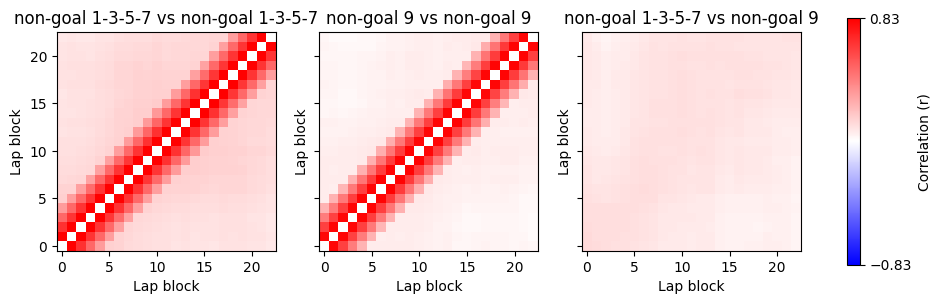

In [ ]:
# Sliding window over laps of pairwise non-goal correlations 
if protocol_num == 5 and mouse == 'TAA0000066':
    num_lms = len(session['all_lms'])
    num_lms_considered = np.round((num_lms // 10) * 10)
    num_laps = int(num_lms_considered / 10)

    landmark_psth, average_landmark_psth = neural_analysis_helpers.get_landmark_psth(data=dF, neurons=neurons_considered, event_idx=all_reward_idx[:num_lms_considered], \
                                                                num_landmarks=session['num_landmarks'], time_around=1)
         
    window_size = 5     # laps 

    non_goal_idx = {}    
    for g, non_goal in enumerate([0,2,4,6,8]):
        non_goal_idx[non_goal] = np.array([idx for idx in session['non_goals_idx'] \
                                if session['all_lms'][idx] == session['non_goal_landmark_id'][g]
                                and (idx < num_lms_considered)])

    # Get rolling non-goal avg
    # psths_considered = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 
    rolling_avg_0246_psth = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 
    rolling_avg_8_psth = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 

    for i in range(num_windows-window_size):
        psths_considered = np.concatenate([landmark_psth[:, non_goal_idx[non_goal][i]:non_goal_idx[non_goal][i+window_size]:session['num_landmarks'], :] for non_goal in [0,2,4,6]], axis=1)
        # shape: num_neurons x window_size * num_goals x num_timebins

        rolling_avg_0246_psth[:, i, :] = np.mean(psths_considered, axis=1) 
        rolling_avg_8_psth[:, i, :] = np.mean(landmark_psth[:, non_goal_idx[8][i]:non_goal_idx[8][i+window_size]:session['num_landmarks'], :], axis=1)
        # shape: num_neurons x num_windows x num_timebins

    # Get the pairwise correlations of rolling lap blocks
    conditions = ['non-goal 1-3-5-7', 'non-goal 9']
    average_psths = [rolling_avg_0246_psth, rolling_avg_8_psth]

    # Get correlation matrix of average psths in rolling lap blocks
    similarity_neural_nongoal = neural_analysis_helpers.get_window_similarity_matrix(average_psths, conditions, population=False, zscoring=True, plot=True)

/var/folders/hb/19x78jb503d4_x8gkyw7xdz00000gn/T/ipykernel_11253/573835124.py:44: RuntimeWarning:

Mean of empty slice

/Users/athinaapostolelli/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/Users/athinaapostolelli/.local/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning:

invalid value encountered in divide

/Users/athinaapostolelli/Documents/SWC/VR_ABCD_project/VR_ABCD/neural_analysis_helpers.py:1054: RuntimeWarning:

Mean of empty slice

/Users/athinaapostolelli/Documents/SWC/VR_ABCD_project/VR_ABCD/neural_analysis_helpers.py:1100: RuntimeWarning:

Mean of empty slice



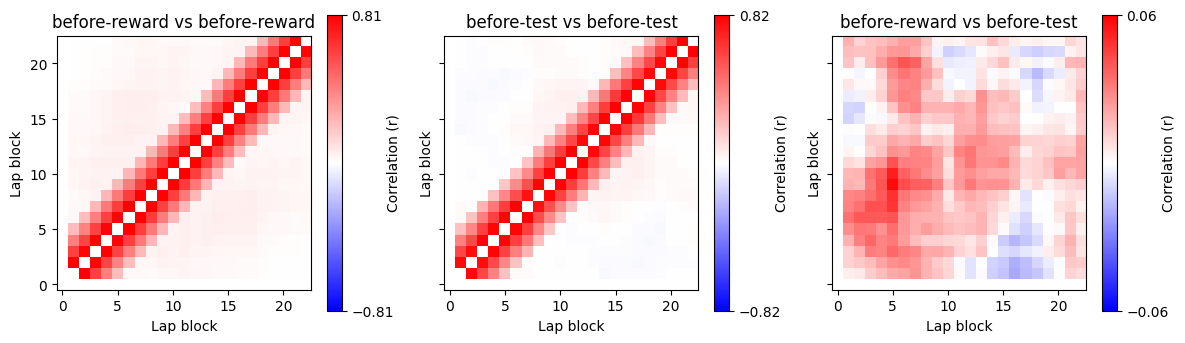

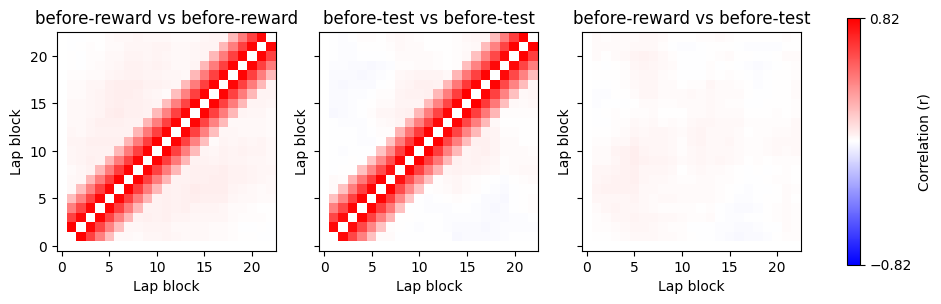

In [ ]:
# Sliding window over laps of pairwise between landmark correlations 
if protocol_num == 5 and mouse == 'TAA0000066':

    # Define 'events' between landmarks 
    num_landmarks = session['num_landmarks']
    num_lms = len(session['all_lms'])
    num_lms_considered = int(np.round((num_lms // 10) * 10))
    num_laps = int(num_lms_considered / num_landmarks)
    lm_entry_idx, lm_exit_idx = parse_session_functions.get_lm_entry_exit(session)

    before_lm = []
    after_lm = []
    for i in np.arange(num_landmarks, num_lms_considered):  # skipping first lap 
        before_lm.append(len(np.arange(lm_exit_idx[i-1], lm_entry_idx[i])))
        after_lm.append(len(np.arange(lm_exit_idx[i], lm_entry_idx[i+1])))

    midpoints_before = np.rint(np.array(before_lm) / 2).astype(int)
    midpoints_after = np.rint(np.array(after_lm) / 2).astype(int)
    min_frames_around = np.min([midpoints_before, midpoints_after])
    # print(min_frames_around)

    new_time_around = min_frames_around / funcimg_frame_rate  # new time around to avoid overlaps with landmark 

    event_indices = []
    for i, idx in enumerate(np.arange(num_landmarks, num_lms_considered)):
        event_indices.append(lm_entry_idx[idx] - midpoints_before[i])

    # Get between-landmark PSTH
    between_landmark_psth, average_between_landmark_psth = neural_analysis_helpers.get_landmark_psth(data=dF, neurons=neurons_considered, event_idx=event_indices, \
                                                                num_landmarks=num_landmarks, time_around=new_time_around)
    
    
    window_size = 5     # laps 
    before_rew_idx = {}    
    for g, goal in enumerate(ABCD_goals):
        before_rew_idx[goal] = np.array([idx for idx in session['goals_idx'] \
                                if session['all_lms'][idx] == session['goal_landmark_id'][goal-1]]) - num_landmarks  # shift indices back - first lap is not considered
        
        num_windows = len(before_rew_idx[goal]) 

    # Get rolling before-reward avg
    rolling_avg_before_reward_psth = np.zeros((between_landmark_psth.shape[0], num_windows-window_size, between_landmark_psth.shape[2])) 
    for i in range(num_windows-window_size):
        psths_considered = np.concatenate([between_landmark_psth[:, before_rew_idx[goal][i]:before_rew_idx[goal][i+window_size]:num_landmarks, :] for goal in ABCD_goals], axis=1)
        # shape: num_neurons x window_size * num_goals x num_timebins

        rolling_avg_before_reward_psth[:, i, :] = np.nanmean(psths_considered, axis=1) 
        # shape: num_neurons x num_windows x num_timebins

    # Get rolling before-test avg
    valid_before_test_idx = np.array([idx for idx in session['test_idx'] if (idx > session['goals_idx'][0] and idx < session['goals_idx'][-1]+3)]) - num_landmarks  # shift indices back - first lap is not considered
    num_windows = int(len(valid_before_test_idx - window_size + 1))
    rolling_avg_before_test_psth = np.zeros((between_landmark_psth.shape[0], num_windows-window_size, between_landmark_psth.shape[2])) 
    
    for i in range(num_windows-window_size):
        rolling_avg_before_test_psth[:, i, :] = np.mean(between_landmark_psth[:, valid_before_test_idx[i]:valid_before_test_idx[i+window_size]:num_landmarks, :], axis=1)

    # Get the pairwise correlations of rolling lap blocks
    conditions = ['before-reward', 'before-test']
    average_psths = [rolling_avg_before_reward_psth, rolling_avg_before_test_psth]

    # Get correlation matrix of average psths in rolling lap blocks
    similarity_neural_between_lm = neural_analysis_helpers.get_window_similarity_matrix(average_psths, conditions, population=False, zscoring=True, plot=True)

#### Correlation sliding window with lick events

In [ ]:
# Get relevant events 
num_lms_considered = np.round((num_lms // 10) * 10)
num_laps = int(num_lms_considered / 10)

first_licks, _ = parse_session_functions.get_first_licks(session, VR_data, nidaq_data)
first_licks = {id: np.array(lst) for id, lst in first_licks.items()}

# Landmark licks and non-licks
lick_ids = [1, 2, 3, 4, 8, 9, 10]
lick_events = np.sort(np.concatenate([first_licks[i] for i in lick_ids]))


Number of licks considered: 339


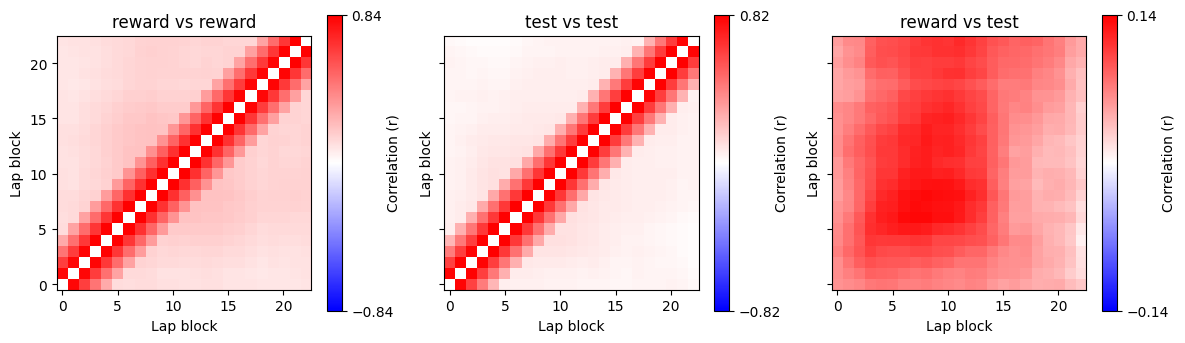

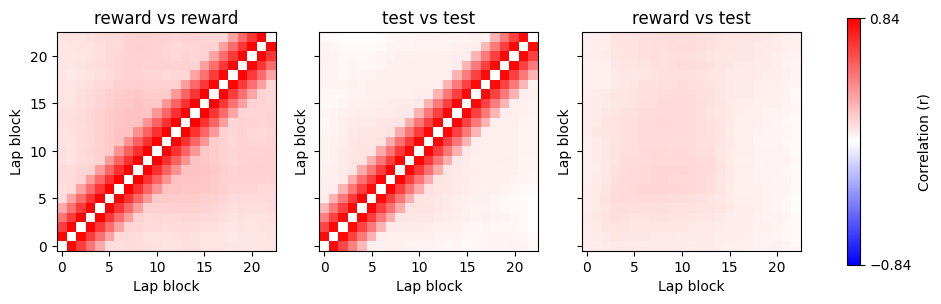

In [ ]:
# Sliding window across T5 reward-licks and test-licks correlations using licks
if protocol_num == 5 and mouse == 'TAA0000066':
    
    # Get landmarks PSTH of fake neuron
    landmark_psth, average_landmark_psth = neural_analysis_helpers.get_landmark_psth(data=dF, neurons=neurons_considered, event_idx=lick_events[:num_lms_considered], \
                                                                num_landmarks=num_landmarks, time_around=1)
         
    # Find rewarded landmarks
    rew_idx = {}    
    for g, goal in enumerate(ABCD_goals):
        rew_idx[goal] = np.array([idx for idx in session['goals_idx'] \
                                if session['all_lms'][idx] == session['goal_landmark_id'][goal-1]])

    # Get rolling reward avg
    window_size = 5     # laps 
    num_windows = len(rew_idx[ABCD_goals[0]]) 
    rolling_avg_reward_psth = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 

    for i in range(num_windows-window_size):
        psths_considered = np.concatenate([landmark_psth[:, rew_idx[goal][i]:rew_idx[goal][i+window_size]:num_landmarks, :] for goal in ABCD_goals], axis=1)
        # shape: num_neurons x window_size * num_goals x num_timebins

        rolling_avg_reward_psth[:, i, :] = np.mean(psths_considered, axis=1) 
        # shape: num_neurons x num_windows x num_timebins

    # Get rolling test avg
    valid_test_indices = np.array([idx for idx in session['test_idx'] if (idx > session['goals_idx'][0] and idx < session['goals_idx'][-1]+3)])
    num_windows = int(len(valid_test_indices - window_size + 1))
    rolling_avg_test_psth = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 
    
    for i in range(num_windows-window_size):
        rolling_avg_test_psth[:, i, :] = np.mean(landmark_psth[:, valid_test_indices[i]:valid_test_indices[i+window_size]:num_landmarks, :], axis=1)

    # Get correlation matrix of average psths in rolling lap blocks
    conditions = ['reward', 'test']
    average_psths = [rolling_avg_reward_psth, rolling_avg_test_psth]

    similarity_matrices = neural_analysis_helpers.get_window_similarity_matrix(average_psths, conditions, population=False, zscoring=True, plot=True)

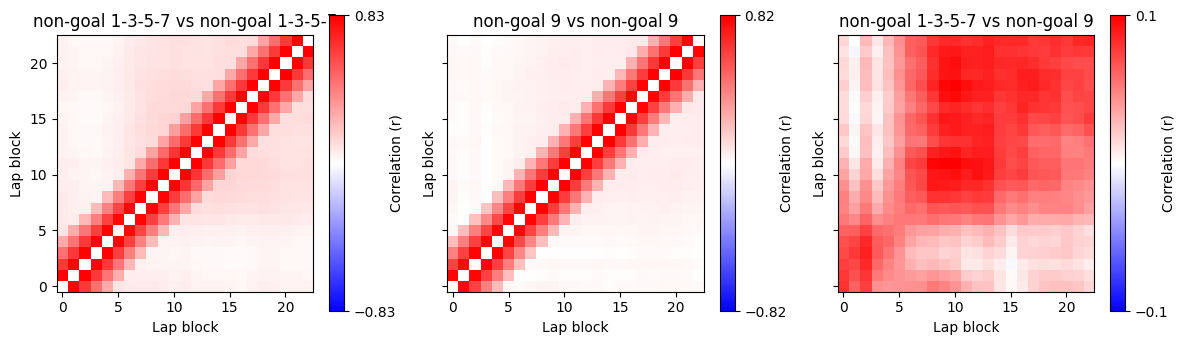

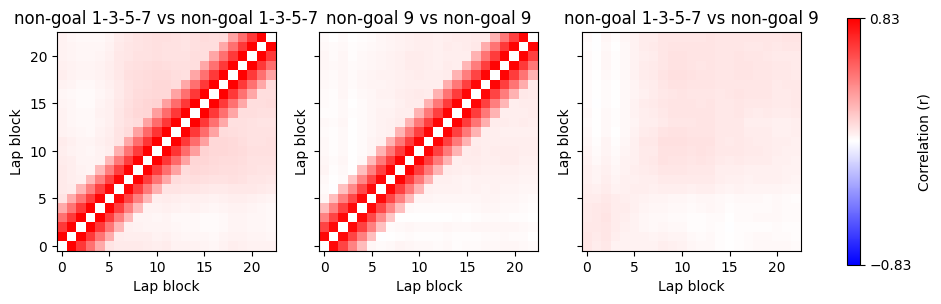

In [ ]:
# Sliding window over laps of pairwise non-goal correlations 
if protocol_num == 5 and mouse == 'TAA0000066':
    
    # Get landmarks PSTH of fake neuron
    landmark_psth, average_landmark_psth = neural_analysis_helpers.get_landmark_psth(data=dF, neurons=neurons_considered, event_idx=lick_events[:num_lms_considered], \
                                                                num_landmarks=num_landmarks, time_around=1)
     
    # Find non-goal landmarks
    non_goal_idx = {}    
    for g, non_goal in enumerate([0,2,4,6,8]):
        non_goal_idx[non_goal] = np.array([idx for idx in session['non_goals_idx'] \
                                if session['all_lms'][idx] == session['non_goal_landmark_id'][g]
                                and (idx < num_lms_considered)])
    num_windows = len(non_goal_idx[0])

    # Get rolling non-goal avg
    window_size = 5     # laps 
    rolling_avg_0246_psth = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 
    rolling_avg_8_psth = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 

    for i in range(num_windows-window_size):
        psths_considered = np.concatenate([landmark_psth[:, non_goal_idx[non_goal][i]:non_goal_idx[non_goal][i+window_size]:num_landmarks, :] for non_goal in [0,2,4,6]], axis=1)
        # shape: num_neurons x window_size * num_goals x num_timebins

        rolling_avg_0246_psth[:, i, :] = np.mean(psths_considered, axis=1) 
        rolling_avg_8_psth[:, i, :] = np.nanmean(landmark_psth[:, non_goal_idx[8][i]:non_goal_idx[8][i+window_size]:num_landmarks, :], axis=1)
        # shape: num_neurons x num_windows x num_timebins

    # Get the pairwise correlations of rolling lap blocks
    conditions = ['non-goal 1-3-5-7', 'non-goal 9']
    average_psths = [rolling_avg_0246_psth, rolling_avg_8_psth]

    # Get correlation matrix of average psths in rolling lap blocks
    similarity_matrices = neural_analysis_helpers.get_window_similarity_matrix(average_psths, conditions, population=False, zscoring=True, plot=True)

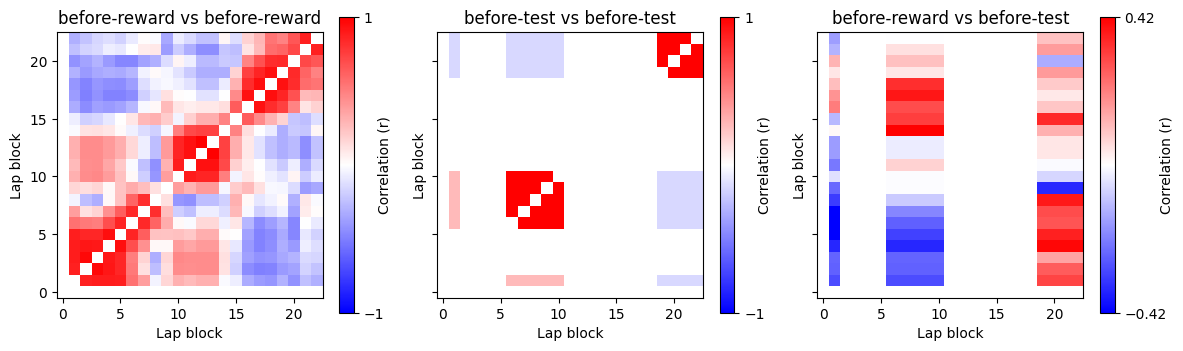

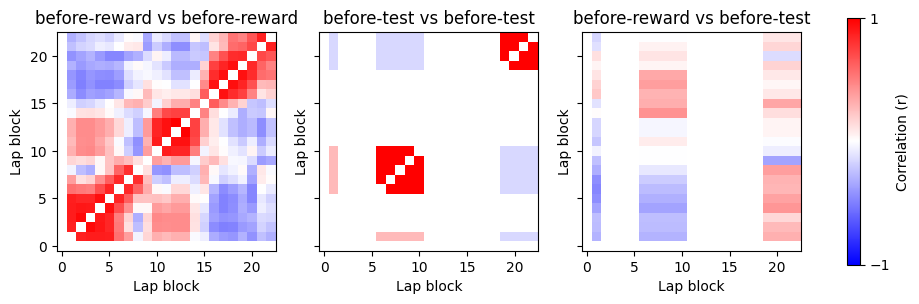

In [ ]:
# TODO: Sliding window over laps of pairwise between landmark correlations 
if protocol_num == 5 and mouse == 'TAA0000066':

    # Define 'events' between landmarks 
    num_lms_considered = int(np.round((num_lms // 10) * 10))
    num_laps = int(num_lms_considered / num_landmarks)

    before_lm = []
    after_lm = []
    for i in np.arange(num_landmarks, num_lms_considered):  # skipping first lap 
        before_lm.append(len(np.arange(lm_exit_idx[i-1], lm_entry_idx[i])))
        after_lm.append(len(np.arange(lm_exit_idx[i], lm_entry_idx[i+1])))

    midpoints_before = np.rint(np.array(before_lm) / 2).astype(int)
    midpoints_after = np.rint(np.array(after_lm) / 2).astype(int)
    min_frames_around = np.min([midpoints_before, midpoints_after])
    # print(min_frames_around)

    new_time_around = min_frames_around / funcimg_frame_rate  # new time around to avoid overlaps with landmark 

    event_indices = []
    for i, idx in enumerate(np.arange(num_landmarks, num_lms_considered)):
        event_indices.append(lm_entry_idx[idx] - midpoints_before[i])

    # Get smoothed lick rate 
    session = parse_session_functions.get_smoothed_lick_rate(nidaq_data, session)
    
    # Get between-landmark PSTH  
    between_landmark_psth, average_between_landmark_psth = neural_analysis_helpers.get_landmark_psth(data=session['smooth_lick_rate'], neurons=0, event_idx=event_indices, \
                                                                num_landmarks=num_landmarks, time_around=new_time_around)
    
    # Find number of 'gray' zones before rewards
    window_size = 5     # laps 
    before_rew_idx = {}    
    for g, goal in enumerate(ABCD_goals):
        before_rew_idx[goal] = np.array([idx for idx in session['goals_idx'] \
                                if session['all_lms'][idx] == session['goal_landmark_id'][goal-1]]) - num_landmarks  # shift indices back - first lap is not considered
        
        num_windows = len(before_rew_idx[goal]) 

    # Get rolling before-reward avg
    rolling_avg_before_reward_psth = np.zeros((between_landmark_psth.shape[0], num_windows-window_size, between_landmark_psth.shape[2])) 
    for i in range(num_windows-window_size):
        psths_considered = np.concatenate([between_landmark_psth[:, before_rew_idx[goal][i]:before_rew_idx[goal][i+window_size]:num_landmarks, :] for goal in ABCD_goals], axis=1)
        # shape: num_neurons x window_size * num_goals x num_timebins

        rolling_avg_before_reward_psth[:, i, :] = np.mean(psths_considered, axis=1) 
        # shape: num_neurons x num_windows x num_timebins

    # Get rolling before-test avg
    valid_before_test_idx = np.array([idx for idx in session['test_idx'] if (idx > session['goals_idx'][0] and idx < session['goals_idx'][-1]+3)]) - num_landmarks  # shift indices back - first lap is not considered
    num_windows = int(len(valid_before_test_idx - window_size + 1))
    rolling_avg_before_test_psth = np.zeros((between_landmark_psth.shape[0], num_windows-window_size, between_landmark_psth.shape[2])) 
    
    for i in range(num_windows-window_size):
        rolling_avg_before_test_psth[:, i, :] = np.mean(between_landmark_psth[:, valid_before_test_idx[i]:valid_before_test_idx[i+window_size]:num_landmarks, :], axis=1)

    # Get the pairwise correlations of rolling lap blocks
    conditions = ['before-reward', 'before-test']
    average_psths = [rolling_avg_before_reward_psth, rolling_avg_before_test_psth]

    # Get correlation matrix of average psths in rolling lap blocks
    similarity_matrices = neural_analysis_helpers.get_window_similarity_matrix(average_psths, conditions, population=False, zscoring=True, plot=True)

#### Correlation sliding window with lick rate

In [ ]:
# Get relevant events and data 
num_lms_considered = np.round((num_lms // 10) * 10)
num_laps = int(num_lms_considered / 10)
    
all_reward_idx = np.sort(np.concatenate([session['reward_idx'], session['miss_rew_idx'], session['nongoal_rew_idx'], session['test_rew_idx']]))

# Get smoothed lick rate 
session = parse_session_functions.get_smoothed_lick_rate(nidaq_data, session)


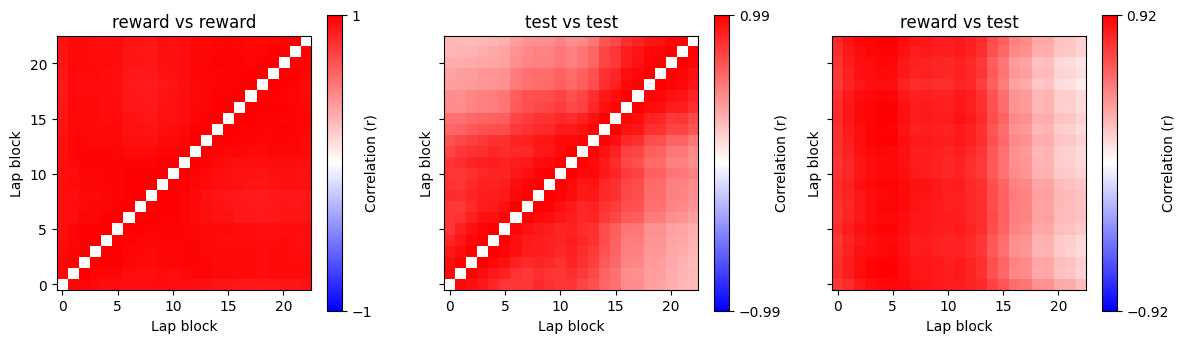

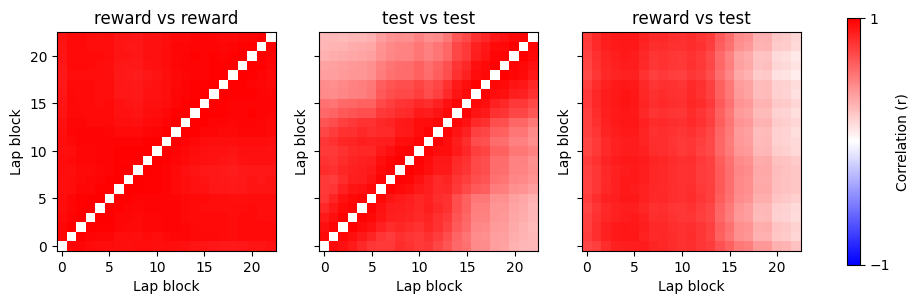

In [ ]:
# Sliding window across T5 reward-licks and test-licks correlations using lick rate as a fake neuron
if protocol_num == 5 and mouse == 'TAA0000066':
    
    # Get landmarks PSTH of fake neuron
    landmark_psth, average_landmark_psth = neural_analysis_helpers.get_landmark_psth(data=session['smooth_lick_rate'], neurons=0, event_idx=all_reward_idx[:num_lms_considered], \
                                                                num_landmarks=num_landmarks, time_around=1)
         
    # Find rewarded landmarks
    rew_idx = {}    
    for g, goal in enumerate(ABCD_goals):
        rew_idx[goal] = np.array([idx for idx in session['goals_idx'] \
                                if session['all_lms'][idx] == session['goal_landmark_id'][goal-1]])

    # Get rolling reward avg
    window_size = 5     # laps 
    num_windows = len(rew_idx[ABCD_goals[0]]) 
    rolling_avg_reward_psth = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 

    for i in range(num_windows-window_size):
        psths_considered = np.concatenate([landmark_psth[:, rew_idx[goal][i]:rew_idx[goal][i+window_size]:num_landmarks, :] for goal in ABCD_goals], axis=1)
        # shape: num_neurons x window_size * num_goals x num_timebins

        rolling_avg_reward_psth[:, i, :] = np.mean(psths_considered, axis=1) 
        # shape: num_neurons x num_windows x num_timebins

    # Get rolling test avg
    valid_test_indices = np.array([idx for idx in session['test_idx'] if (idx > session['goals_idx'][0] and idx < session['goals_idx'][-1]+3)])
    num_windows = int(len(valid_test_indices - window_size + 1))
    rolling_avg_test_psth = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 
    
    for i in range(num_windows-window_size):
        rolling_avg_test_psth[:, i, :] = np.mean(landmark_psth[:, valid_test_indices[i]:valid_test_indices[i+window_size]:num_landmarks, :], axis=1)

    # Get correlation matrix of average psths in rolling lap blocks
    conditions = ['reward', 'test']
    average_psths = [rolling_avg_reward_psth, rolling_avg_test_psth]

    similarity_lickRate_rew_test = neural_analysis_helpers.get_window_similarity_matrix(average_psths, conditions, population=False, zscoring=True, plot=True)

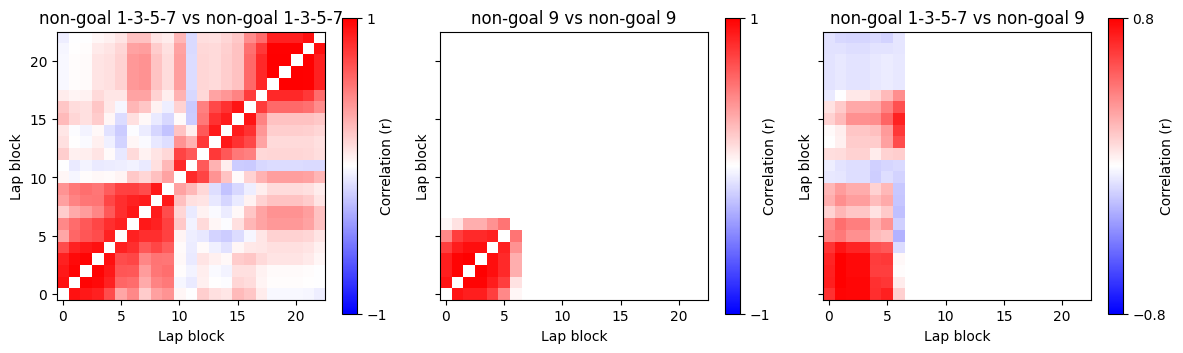

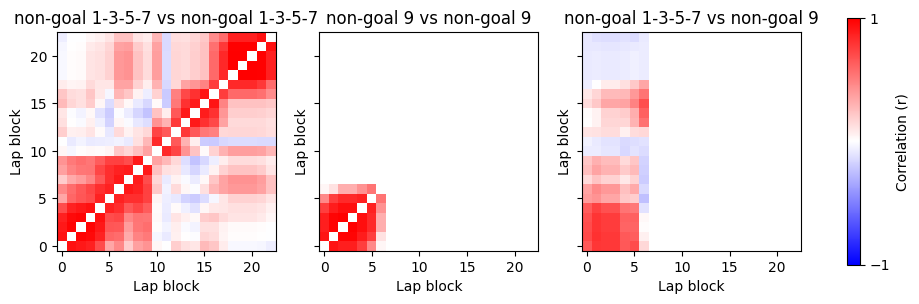

In [ ]:
# Sliding window over laps of pairwise non-goal correlations 
if protocol_num == 5 and mouse == 'TAA0000066':
    
    # Get landmarks PSTH of fake neuron
    landmark_psth, average_landmark_psth = neural_analysis_helpers.get_landmark_psth(data=session['smooth_lick_rate'], neurons=0, event_idx=all_reward_idx[:num_lms_considered], \
                                                                num_landmarks=num_landmarks, time_around=1)
     
    # Find non-goal landmarks
    non_goal_idx = {}    
    for g, non_goal in enumerate([0,2,4,6,8]):
        non_goal_idx[non_goal] = np.array([idx for idx in session['non_goals_idx'] \
                                if session['all_lms'][idx] == session['non_goal_landmark_id'][g]
                                and (idx < num_lms_considered)])
    num_windows = len(non_goal_idx[0])

    # Get rolling non-goal avg
    window_size = 5     # laps 
    rolling_avg_0246_psth = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 
    rolling_avg_8_psth = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 

    for i in range(num_windows-window_size):
        psths_considered = np.concatenate([landmark_psth[:, non_goal_idx[non_goal][i]:non_goal_idx[non_goal][i+window_size]:num_landmarks, :] for non_goal in [0,2,4,6]], axis=1)
        # shape: num_neurons x window_size * num_goals x num_timebins

        rolling_avg_0246_psth[:, i, :] = np.mean(psths_considered, axis=1) 
        rolling_avg_8_psth[:, i, :] = np.nanmean(landmark_psth[:, non_goal_idx[8][i]:non_goal_idx[8][i+window_size]:num_landmarks, :], axis=1)
        # shape: num_neurons x num_windows x num_timebins

    # Get the pairwise correlations of rolling lap blocks
    conditions = ['non-goal 1-3-5-7', 'non-goal 9']
    average_psths = [rolling_avg_0246_psth, rolling_avg_8_psth]

    # Get correlation matrix of average psths in rolling lap blocks
    similarity_lickRate_nongoal = neural_analysis_helpers.get_window_similarity_matrix(average_psths, conditions, population=False, zscoring=True, plot=True)

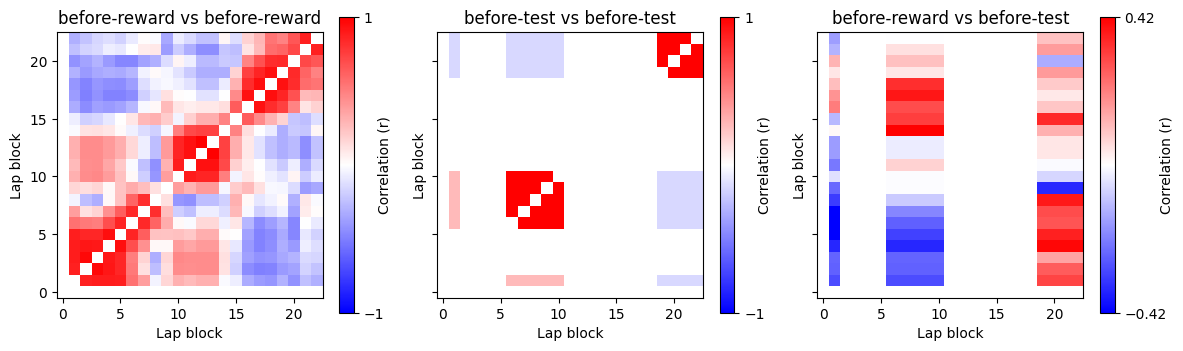

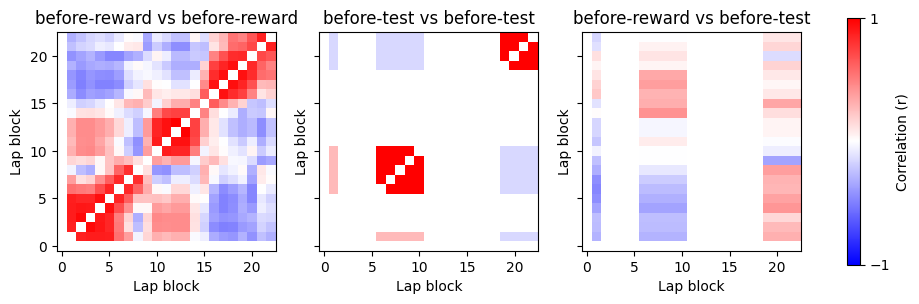

In [ ]:
# Sliding window over laps of pairwise between landmark correlations 
if protocol_num == 5 and mouse == 'TAA0000066':

    # Define 'events' between landmarks 
    before_lm = []
    after_lm = []
    for i in np.arange(num_landmarks, num_lms_considered):  # skipping first lap 
        before_lm.append(len(np.arange(lm_exit_idx[i-1], lm_entry_idx[i])))
        after_lm.append(len(np.arange(lm_exit_idx[i], lm_entry_idx[i+1])))

    midpoints_before = np.rint(np.array(before_lm) / 2).astype(int)
    midpoints_after = np.rint(np.array(after_lm) / 2).astype(int)
    min_frames_around = np.min([midpoints_before, midpoints_after])
    # print(min_frames_around)

    new_time_around = min_frames_around / funcimg_frame_rate  # new time around to avoid overlaps with landmark 

    event_indices = []
    for i, idx in enumerate(np.arange(num_landmarks, num_lms_considered)):
        event_indices.append(lm_entry_idx[idx] - midpoints_before[i])

    # Get smoothed lick rate 
    session = parse_session_functions.get_smoothed_lick_rate(nidaq_data, session)
    
    # Get between-landmark PSTH  
    between_landmark_psth, average_between_landmark_psth = neural_analysis_helpers.get_landmark_psth(data=session['smooth_lick_rate'], neurons=0, event_idx=event_indices, \
                                                                num_landmarks=num_landmarks, time_around=new_time_around)
    
    # Find number of 'gray' zones before rewards
    window_size = 5     # laps 
    before_rew_idx = {}    
    for g, goal in enumerate(ABCD_goals):
        before_rew_idx[goal] = np.array([idx for idx in session['goals_idx'] \
                                if session['all_lms'][idx] == session['goal_landmark_id'][goal-1]]) - num_landmarks  # shift indices back - first lap is not considered
        
        num_windows = len(before_rew_idx[goal]) 

    # Get rolling before-reward avg
    rolling_avg_before_reward_psth = np.zeros((between_landmark_psth.shape[0], num_windows-window_size, between_landmark_psth.shape[2])) 
    for i in range(num_windows-window_size):
        psths_considered = np.concatenate([between_landmark_psth[:, before_rew_idx[goal][i]:before_rew_idx[goal][i+window_size]:num_landmarks, :] for goal in ABCD_goals], axis=1)
        # shape: num_neurons x window_size * num_goals x num_timebins

        rolling_avg_before_reward_psth[:, i, :] = np.mean(psths_considered, axis=1) 
        # shape: num_neurons x num_windows x num_timebins

    # Get rolling before-test avg
    valid_before_test_idx = np.array([idx for idx in session['test_idx'] if (idx > session['goals_idx'][0] and idx < session['goals_idx'][-1]+3)]) - num_landmarks  # shift indices back - first lap is not considered
    num_windows = int(len(valid_before_test_idx - window_size + 1))
    rolling_avg_before_test_psth = np.zeros((between_landmark_psth.shape[0], num_windows-window_size, between_landmark_psth.shape[2])) 
    
    for i in range(num_windows-window_size):
        rolling_avg_before_test_psth[:, i, :] = np.mean(between_landmark_psth[:, valid_before_test_idx[i]:valid_before_test_idx[i+window_size]:num_landmarks, :], axis=1)

    # Get the pairwise correlations of rolling lap blocks
    conditions = ['before-reward', 'before-test']
    average_psths = [rolling_avg_before_reward_psth, rolling_avg_before_test_psth]

    # Get correlation matrix of average psths in rolling lap blocks
    similarity_lickRate_between_lm = neural_analysis_helpers.get_window_similarity_matrix(average_psths, conditions, population=False, zscoring=True, plot=True)

#### t-test around behaviour boundaries 

In [ ]:
# Perform a t-test around the behaviour boundaries 

# Collect the relevant data
all_reward_idx = np.sort(np.concatenate([session['reward_idx'], session['miss_rew_idx'], session['nongoal_rew_idx'], session['test_rew_idx']]))

landmark_psth, average_landmark_psth = neural_analysis_helpers.get_landmark_psth(data=dF, neurons=neurons_considered, event_idx=all_reward_idx[:num_lms_considered], \
                                                            num_landmarks=num_landmarks, time_around=1)

# Split trials into behaviour segments
split_indices = {}
for i in range(3):
    if i == 0:
        trials = np.arange(0, 70)   # laps 0-7
    elif i == 1:
        trials = np.arange(70, 200)     # laps 7-20
    elif i == 2:
        trials = np.arange(200, num_lms)   # laps 20-end

    split_indices[i] = valid_test_indices[np.isin(valid_test_indices, trials)]

# Split psths into behaviour segments
split_test_psths = [landmark_psth[:, split_idx, :] for id, split_idx in split_indices.items()]

# Take average across timebins for each neuron and each trial 
split_average_test_psths = [np.mean(psth, axis=2) for psth in split_test_psths]
# for split in split_average_test_psths:
#     print(split.shape)


{0: array([39, 49, 59, 69])}
{0: array([39, 49, 59, 69]), 1: array([ 79,  89,  99, 109, 119, 129, 139, 149, 159, 169, 179, 189, 199])}
{0: array([39, 49, 59, 69]), 1: array([ 79,  89,  99, 109, 119, 129, 139, 149, 159, 169, 179, 189, 199]), 2: array([209, 219, 229, 239, 249, 259, 269, 279])}


110
[  0   1   2   3   6   8   9  12  13  14  16  21  23  25  27  29  30  33
  34  41  44  47  48  50  51  52  53  54  56  59  63  64  66  72  73  75
  76  80  81  85  86  92  93  96 101 104 106 110 112 114 115 122 123 124
 125 127 129 130 131 134 137 138 141 143 146 147 153 154 158 163 166 167
 170 171 172 173 180 185 186 192 193 198 200 206 209 210 211 217 218 220
 221 222 224 225 226 227 228 231 233 234 235 236 240 242 246 248 249 251
 254 255 259 262 266 268 271 276 278 279 281 282 285 287 288 289 293 294
 296 297 298 301 306 307 308 309 311 312 313 314 316 317 318 323 325 328
 331 333 334 335 336 337 338 339 343 344 345 346 347 348 353 356 359 361
 362 365 366 367 368 369 370 371 373 374 375 376 377 378 380 381 382 384
 385 387 390 392 393 394 395 396 398 400 402 405 406 409 410 412 413 414
 417 424 426 427 431 432 433 435 437 438 441 442 443 444 446 447 448 452
 453 454 455 459 461 462 463 464 465 467 470 473 475 476 477 479 483 484
 485 487 489 493 494 495 496 498 499 503 504 50

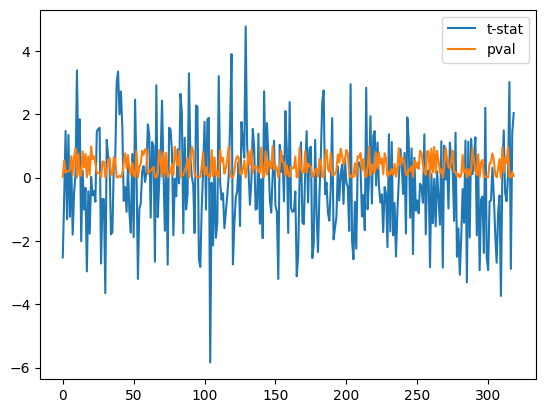

In [ ]:
# two-sided t-test for each neuron in alternation vs discrimination (assume equal population variances)
t_stat, t_pval = stats.ttest_ind(split_average_test_psths[1], split_average_test_psths[2], axis=1, \
                                        equal_var=True, nan_policy='raise') 

plt.scatter(t_stat, label='t-stat')
plt.scatter(t_pval, label='pval')
plt.legend()
# Set arbitrary t-value threshold to 2 
test_neurons = neurons_considered[np.where(np.abs(t_stat) > 1.5)[0]]
# print(len(test_neurons))

# print(neurons_considered)

remaining_neurons = np.setdiff1d(neurons_considered, test_neurons)
# print(remaining_neurons)

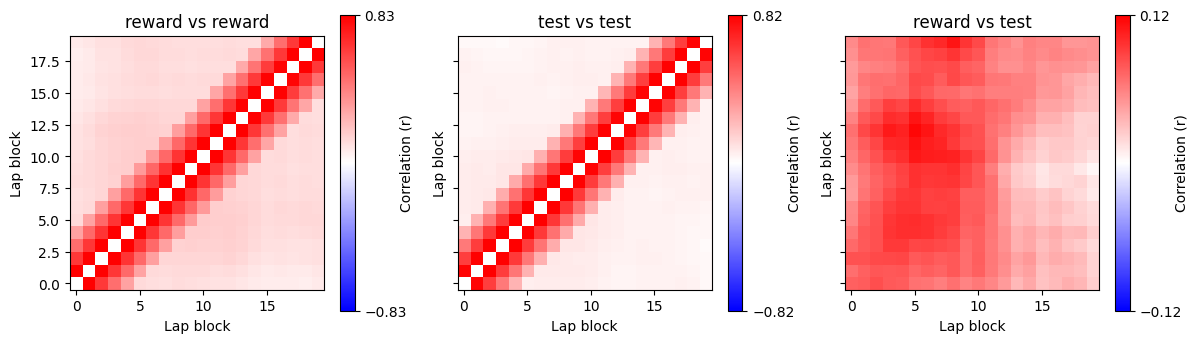

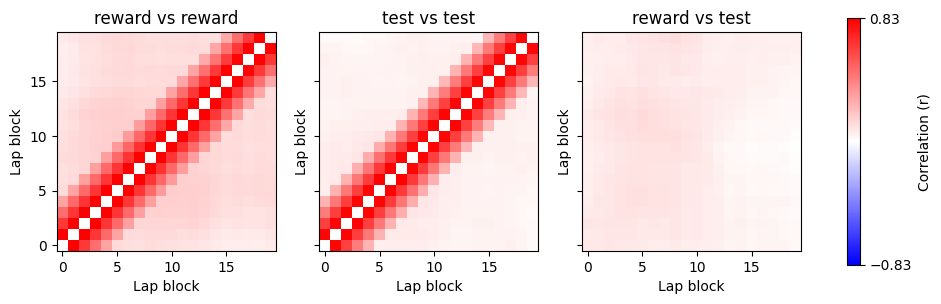

In [ ]:
# Remove these neurons are repeat correlations (reward-locked activity)
# Sliding window across T5 reward and test correlations
if protocol_num == 5 and mouse == 'TAA0000066':
    num_lms_considered = np.round((num_lms // 10) * 10)
    ABCD_goals = [1,2,3,4]
    all_reward_idx = np.sort(np.concatenate([session['reward_idx'], session['miss_rew_idx'], session['nongoal_rew_idx'], session['test_rew_idx']]))

    landmark_psth, average_landmark_psth = neural_analysis_helpers.get_landmark_psth(data=dF, neurons=remaining_neurons, event_idx=all_reward_idx[:num_lms_considered], \
                                                                num_landmarks=num_landmarks, time_around=1)
         
    window_size = 5     # laps 
    
    # Get rolling reward avg
    rew_idx = {}    
    for g, goal in enumerate(ABCD_goals):
        rew_idx[goal] = np.array([idx for idx in session['rewarded_landmarks'] \
                                if session['all_lms'][idx] == session['goal_landmark_id'][goal-1]])
        
        num_windows = len(rew_idx[goal]) 

    rolling_avg_reward_psth = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 

    for i in range(num_windows-window_size):
        psths_considered = np.concatenate([landmark_psth[:, rew_idx[goal][i]:rew_idx[goal][i+window_size]:num_landmarks, :] for goal in ABCD_goals], axis=1)
        # shape: num_neurons x window_size * num_goals x num_timebins

        rolling_avg_reward_psth[:, i, :] = np.mean(psths_considered, axis=1) 
        # shape: num_neurons x num_windows x num_timebins

    # Get rolling test avg
    valid_test_indices = np.array([idx for idx in session['test_idx'] if (idx > session['rewarded_landmarks'][0] and idx < session['rewarded_landmarks'][-1]+3)])
    num_windows = int(len(valid_test_indices - window_size + 1))
    rolling_avg_test_psth = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 
    
    for i in range(num_windows-window_size):
        rolling_avg_test_psth[:, i, :] = np.mean(landmark_psth[:, valid_test_indices[i]:valid_test_indices[i+window_size]:num_landmarks, :], axis=1)

    # Get the pairwise correlations of rolling lap blocks
    conditions = ['reward', 'test']
    average_psths = [rolling_avg_reward_psth, rolling_avg_test_psth]

    # Get correlation matrix of average psths in rolling lap blocks
    similarity_matrices = neural_analysis_helpers.get_window_similarity_matrix(average_psths, conditions, population=False, zscoring=True, plot=True)

#### Difference in correlation sliding window (neural activity and lick rate)
The goal of this analysis is to compare the neural activity correlations with the correlations observed just based on the lick rate. The difference between the two might reveal patterns that are only present in the neural data

##### z-scoring and taking the difference

In [79]:
# Format the matrices to allow z-scoring
neural_data = similarity_neural_between_lm # similarity_neural_nongoal # similarity_neural_rew_test
lick_data = similarity_lickRate_between_lm
# conditions = ['reward', 'test']
# conditions = ['non-goal 1-3-5-7', 'non-goal 9']
conditions = ['before-reward', 'before-test']

def remove_nan(mat):
    mat_no_nan = mat.copy()
    mat_no_nan[np.isnan(mat_no_nan)] = 1
    return mat_no_nan

def add_nan(mat1, mat2):
    mat_nan = mat1.copy()
    mat2[np.isnan(mat_nan)] = np.nan
    return mat2


similarity_neural_clean = [remove_nan(mat) for mat in neural_data]
similarity_lick_clean = [remove_nan(mat) for mat in lick_data]

# Z-score the relevant similarity matrices
neural_z = [zscore(mat, axis=None) for mat in similarity_neural_clean]
lick_z = [zscore(mat, axis=None) for mat in similarity_lick_clean]

# Calculate the difference
neural_lick_diff_z = [neural_z[i] - lick_z[i] for i in range(len(neural_z))]

# Format the matrices for plotting
neural_lick_diff = [add_nan(mat1, mat2) for mat1, mat2 in zip(lick_z, neural_lick_diff_z)]


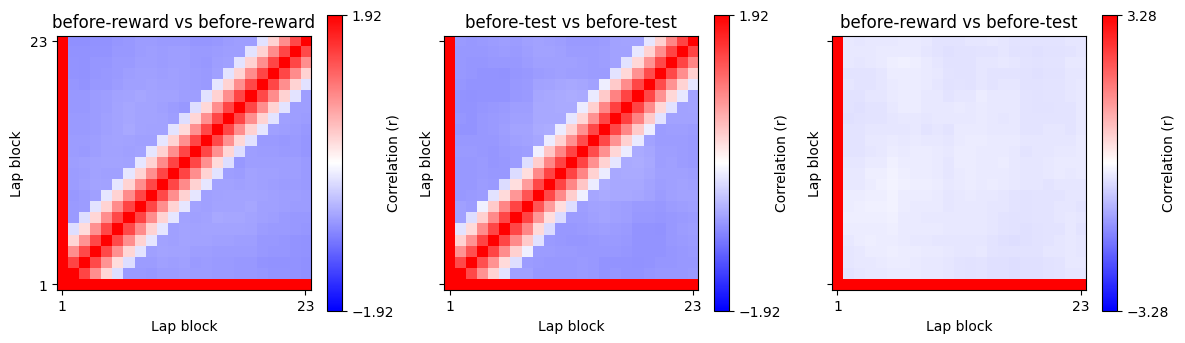

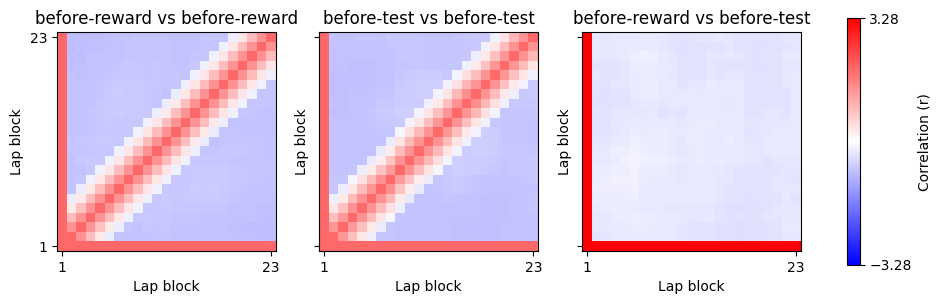

In [80]:
# Plot each z-scored matrix
condition_pairs = list(itertools.combinations(range(len(conditions)), 2))

fig, ax = plt.subplots(1, len(neural_z), figsize=(12,4), sharex=True, sharey=True)
ax = ax.ravel()

for i, sim_matrix in enumerate(neural_z):
    vmax = np.round(np.nanmax(sim_matrix), 2)
    if vmax < 1e-3:
        vmax = 1e-3
    vmin = -vmax
    im = ax[i].imshow(sim_matrix, vmin=vmin, vmax=vmax, cmap='bwr', origin='lower')
    
    cb = fig.colorbar(im, ax=ax[i], shrink=0.8, ticks=[vmin, vmax])  
    cb.set_label('Correlation (r)', labelpad=-5)

    if i < len(conditions):
        ax[i].set_title(f"{conditions[i]} vs {conditions[i]}")
    else:
        ax[i].set_title(f"{conditions[int(condition_pairs[0][0])]} vs {conditions[int(condition_pairs[0][1])]}")
    ax[i].set_xticks([0, sim_matrix.shape[0]-1])
    ax[i].set_xticklabels([1, sim_matrix.shape[0]])
    ax[i].set_yticks([0, sim_matrix.shape[0]-1])
    ax[i].set_yticklabels([1, sim_matrix.shape[0]])
    ax[i].set_xlabel("Lap block")
    ax[i].set_ylabel("Lap block")
plt.tight_layout()

# Global colormap
all_values = np.concatenate([sim[~np.isnan(sim)].flatten() for sim in neural_z])
vmax = np.round(np.max(all_values), 2)
vmin = -vmax

fig, ax = plt.subplots(1, len(neural_z), figsize=(12,4), sharex=True, sharey=True)
ax = ax.ravel()

for i, sim_matrix in enumerate(neural_z):
    im = ax[i].imshow(sim_matrix, vmin=vmin, vmax=vmax, cmap='bwr', origin='lower')

    if i < len(conditions):
        ax[i].set_title(f"{conditions[i]} vs {conditions[i]}")
    else:
        ax[i].set_title(f"{conditions[int(condition_pairs[0][0])]} vs {conditions[int(condition_pairs[0][1])]}")
    ax[i].set_xticks([0, sim_matrix.shape[0]-1])
    ax[i].set_xticklabels([1, sim_matrix.shape[0]])
    ax[i].set_yticks([0, sim_matrix.shape[0]-1])
    ax[i].set_yticklabels([1, sim_matrix.shape[0]])
    ax[i].set_xlabel("Lap block")
    ax[i].set_ylabel("Lap block")
# plt.tight_layout()
fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.8, label='Correlation (r)', ticks=[vmin, vmax])


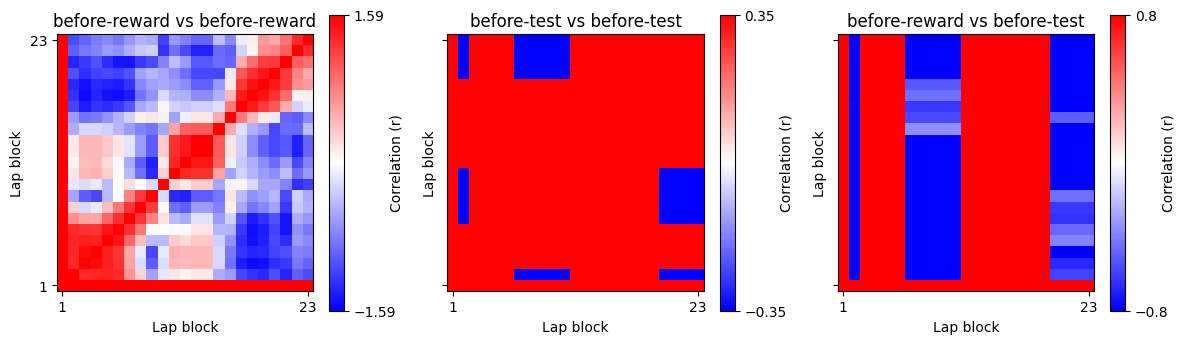

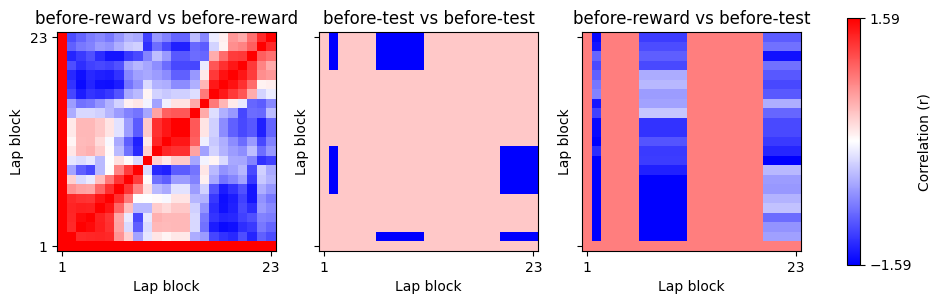

In [81]:
# Plot each z-scored matrix
condition_pairs = list(itertools.combinations(range(len(conditions)), 2))

fig, ax = plt.subplots(1, len(lick_z), figsize=(12,4), sharex=True, sharey=True)
ax = ax.ravel()

for i, sim_matrix in enumerate(lick_z):
    vmax = np.round(np.nanmax(sim_matrix), 2)
    if vmax < 1e-3:
        vmax = 1e-3
    vmin = -vmax
    im = ax[i].imshow(sim_matrix, vmin=vmin, vmax=vmax, cmap='bwr', origin='lower')
    
    cb = fig.colorbar(im, ax=ax[i], shrink=0.8, ticks=[vmin, vmax])  
    cb.set_label('Correlation (r)', labelpad=-5)

    if i < len(conditions):
        ax[i].set_title(f"{conditions[i]} vs {conditions[i]}")
    else:
        ax[i].set_title(f"{conditions[int(condition_pairs[0][0])]} vs {conditions[int(condition_pairs[0][1])]}")
    ax[i].set_xticks([0, sim_matrix.shape[0]-1])
    ax[i].set_xticklabels([1, sim_matrix.shape[0]])
    ax[i].set_yticks([0, sim_matrix.shape[0]-1])
    ax[i].set_yticklabels([1, sim_matrix.shape[0]])
    ax[i].set_xlabel("Lap block")
    ax[i].set_ylabel("Lap block")
plt.tight_layout()

# Global colormap
all_values = np.concatenate([sim[~np.isnan(sim)].flatten() for sim in lick_z])
vmax = np.round(np.nanmax(all_values), 2)
vmin = -vmax

fig, ax = plt.subplots(1, len(lick_z), figsize=(12,4), sharex=True, sharey=True)
ax = ax.ravel()

for i, sim_matrix in enumerate(lick_z):
    im = ax[i].imshow(sim_matrix, vmin=vmin, vmax=vmax, cmap='bwr', origin='lower')

    if i < len(conditions):
        ax[i].set_title(f"{conditions[i]} vs {conditions[i]}")
    else:
        ax[i].set_title(f"{conditions[int(condition_pairs[0][0])]} vs {conditions[int(condition_pairs[0][1])]}")
    ax[i].set_xticks([0, sim_matrix.shape[0]-1])
    ax[i].set_xticklabels([1, sim_matrix.shape[0]])
    ax[i].set_yticks([0, sim_matrix.shape[0]-1])
    ax[i].set_yticklabels([1, sim_matrix.shape[0]])
    ax[i].set_xlabel("Lap block")
    ax[i].set_ylabel("Lap block")
# plt.tight_layout()
fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.8, label='Correlation (r)', ticks=[vmin, vmax])


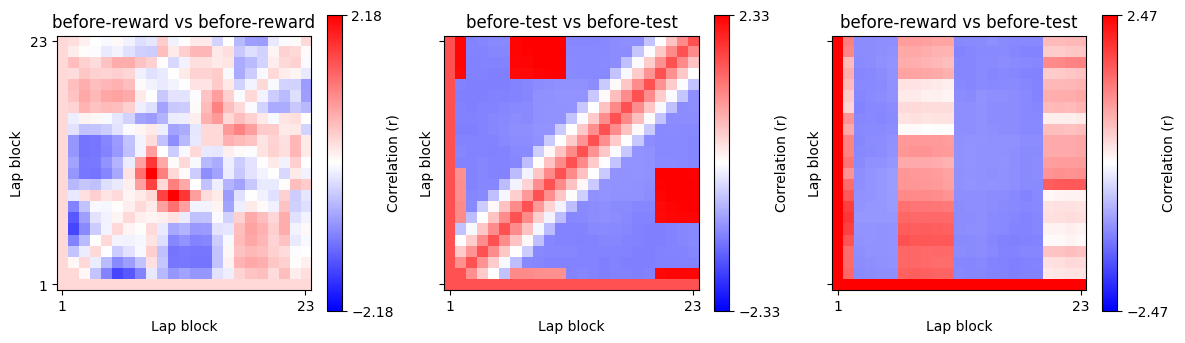

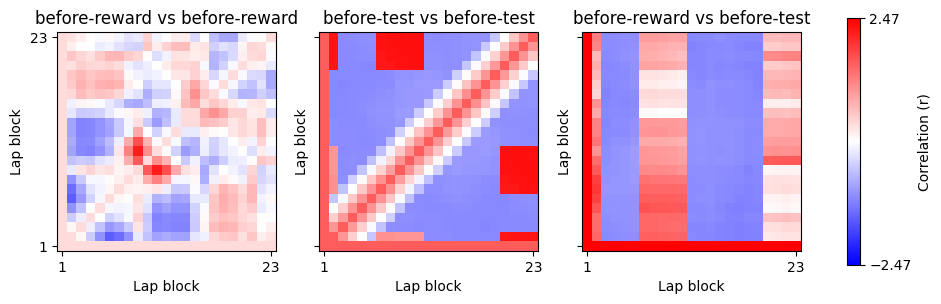

In [82]:
# Plot the difference
condition_pairs = list(itertools.combinations(range(len(conditions)), 2))

fig, ax = plt.subplots(1, len(neural_lick_diff), figsize=(12,4), sharex=True, sharey=True)
ax = ax.ravel()

for i, sim_matrix in enumerate(neural_lick_diff):
    vmax = np.round(np.nanmax(sim_matrix), 2)
    if vmax < 1e-3:
        vmax = 1e-3
    vmin = -vmax
    im = ax[i].imshow(sim_matrix, vmin=vmin, vmax=vmax, cmap='bwr', origin='lower')
    
    cb = fig.colorbar(im, ax=ax[i], shrink=0.8, ticks=[vmin, vmax])  
    cb.set_label('Correlation (r)', labelpad=-5)

    if i < len(conditions):
        ax[i].set_title(f"{conditions[i]} vs {conditions[i]}")
    else:
        ax[i].set_title(f"{conditions[int(condition_pairs[0][0])]} vs {conditions[int(condition_pairs[0][1])]}")
    ax[i].set_xticks([0, sim_matrix.shape[0]-1])
    ax[i].set_xticklabels([1, sim_matrix.shape[0]])
    ax[i].set_yticks([0, sim_matrix.shape[0]-1])
    ax[i].set_yticklabels([1, sim_matrix.shape[0]])
    ax[i].set_xlabel("Lap block")
    ax[i].set_ylabel("Lap block")
plt.tight_layout()

# Global colormap
all_values = np.concatenate([sim[~np.isnan(sim)].flatten() for sim in neural_lick_diff])
vmax = np.round(np.max(all_values), 2)
vmin = -vmax

fig, ax = plt.subplots(1, len(neural_lick_diff), figsize=(12,4), sharex=True, sharey=True)
ax = ax.ravel()

for i, sim_matrix in enumerate(neural_lick_diff):
    im = ax[i].imshow(sim_matrix, vmin=vmin, vmax=vmax, cmap='bwr', origin='lower')

    if i < len(conditions):
        ax[i].set_title(f"{conditions[i]} vs {conditions[i]}")
    else:
        ax[i].set_title(f"{conditions[int(condition_pairs[0][0])]} vs {conditions[int(condition_pairs[0][1])]}")
    ax[i].set_xticks([0, sim_matrix.shape[0]-1])
    ax[i].set_xticklabels([1, sim_matrix.shape[0]])
    ax[i].set_yticks([0, sim_matrix.shape[0]-1])
    ax[i].set_yticklabels([1, sim_matrix.shape[0]])
    ax[i].set_xlabel("Lap block")
    ax[i].set_ylabel("Lap block")
# plt.tight_layout()
fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.8, label='Correlation (r)', ticks=[vmin, vmax])


##### Fit linear regression model and compute residuals 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     344.7
Date:                Thu, 31 Jul 2025   Prob (F-statistic):           5.18e-59
Time:                        09:21:40   Log-Likelihood:                 130.46
No. Observations:                 506   AIC:                            -256.9
Df Residuals:                     504   BIC:                            -248.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.2706      0.299    -17.642      0.0

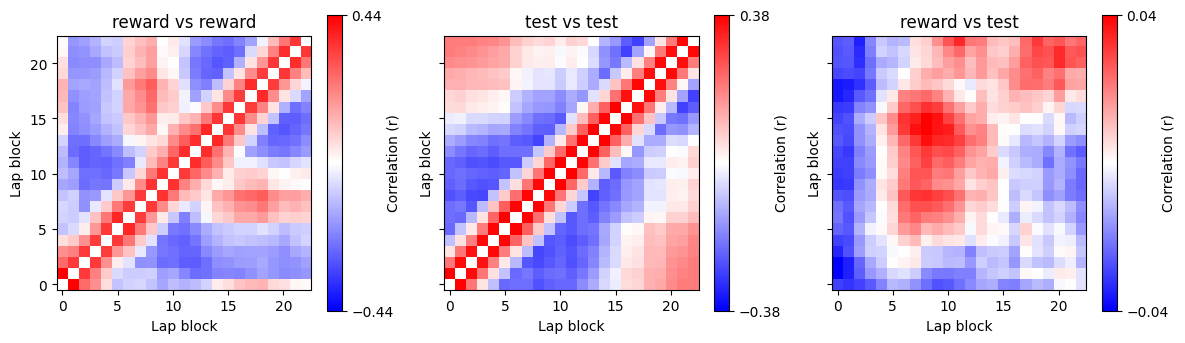

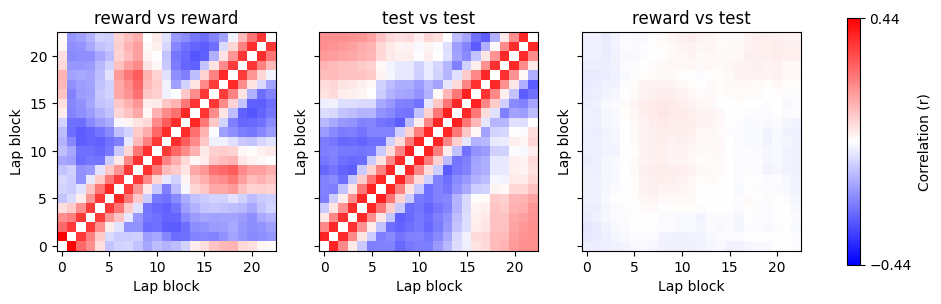

In [ ]:
# Get the residuals from a linear regression fit 
glm_residuals_rew_test = neural_analysis_helpers.get_glm_residuals(x=similarity_lickRate_rew_test, y=similarity_neural_rew_test, plot=True, conditions=['reward', 'test'])


#### Repeat the above analysis for laps instead of lap blocks

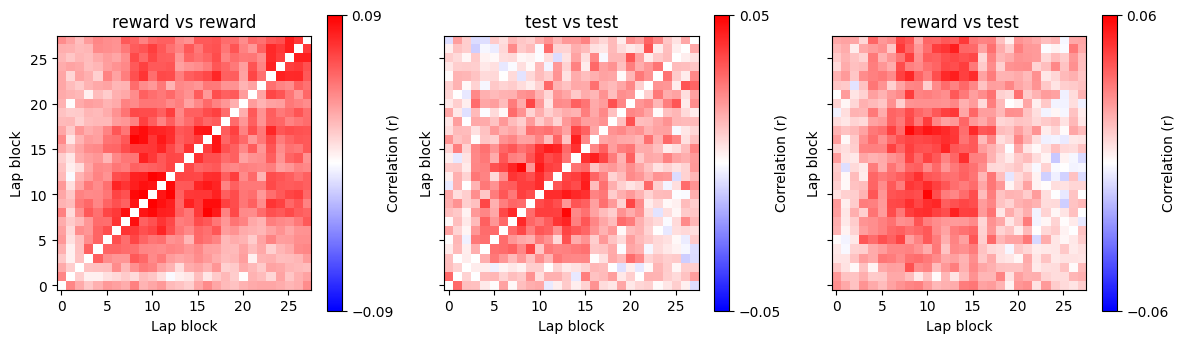

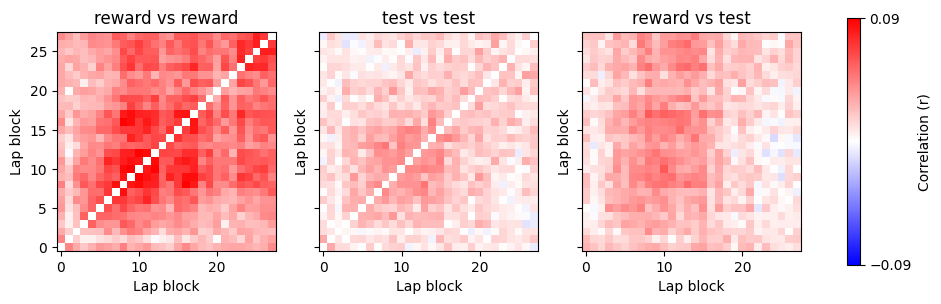

In [ ]:
# Get the pairwise correlations of laps with neural data
if protocol_num == 5 and mouse == 'TAA0000066':
    num_lms_considered = np.round((num_lms // 10) * 10)

    all_reward_idx = np.sort(np.concatenate([session['reward_idx'], session['miss_rew_idx'], session['nongoal_rew_idx'], session['test_rew_idx']]))

    landmark_psth, average_landmark_psth = neural_analysis_helpers.get_landmark_psth(data=dF, neurons=neurons_considered, event_idx=all_reward_idx[:num_lms_considered], \
                                                                num_landmarks=num_landmarks, time_around=1)
    
    # TODO get_reward_idx_by_goal
    rew_idx = {}    
    for g, goal in enumerate(ABCD_goals):
        rew_idx[goal] = np.array([idx for idx in session['goals_idx'] \
                                if session['all_lms'][idx] == session['goal_landmark_id'][goal-1]])
        
        num_windows = len(rew_idx[goal]) 

    first_lap = int(np.floor(rew_idx[1][0] // 10))

    lap_avg_reward_psth = np.zeros((landmark_psth.shape[0], num_windows, landmark_psth.shape[2])) 
    for i in range(num_windows):
        psths_considered = np.stack([landmark_psth[:, rew_idx[goal][i], :] for goal in ABCD_goals], axis=1)
        # shape: num_neurons x num_windows * num_goals x num_timebins

        lap_avg_reward_psth[:, i, :] = np.mean(psths_considered, axis=1) 
        # shape: num_neurons x num_windows x num_timebins

    lap_avg_test_psth = np.zeros((landmark_psth.shape[0], num_windows, landmark_psth.shape[2])) 
    for i in range(num_windows):
        lap_avg_test_psth[:, i, :] = landmark_psth[:, valid_test_indices[i], :]

# Get correlation matrix of average psths in rolling lap blocks
conditions = ['reward', 'test']
average_psths = [lap_avg_reward_psth, lap_avg_test_psth]

similarity_neural_rew_test_laps = neural_analysis_helpers.get_window_similarity_matrix(average_psths, conditions, population=False, zscoring=True, plot=True)

/Users/athinaapostolelli/Documents/SWC/VR_ABCD_project/VR_ABCD/neural_analysis_helpers.py:1054: RuntimeWarning:

Mean of empty slice

/Users/athinaapostolelli/Documents/SWC/VR_ABCD_project/VR_ABCD/neural_analysis_helpers.py:1100: RuntimeWarning:

Mean of empty slice



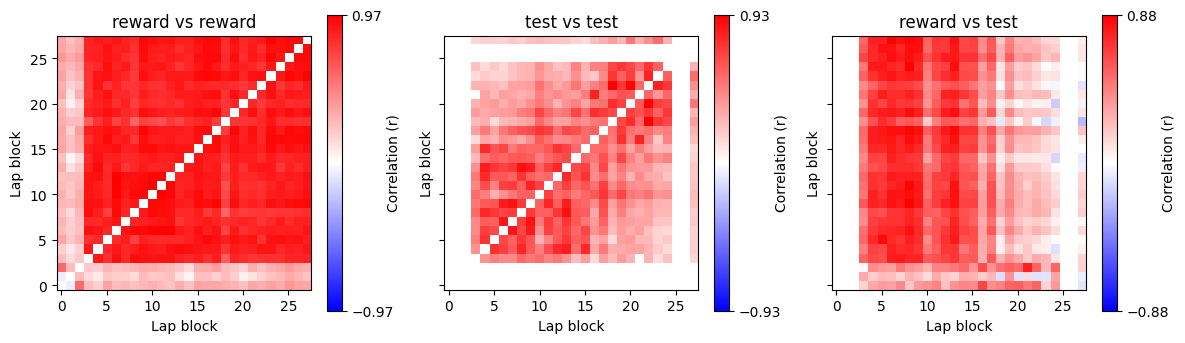

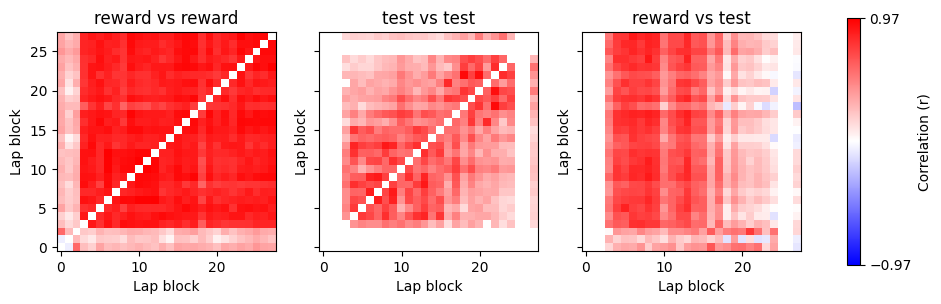

In [ ]:
# Get the pairwise correlations of laps with lick rate
if protocol_num == 5 and mouse == 'TAA0000066':
    num_lms_considered = np.round((num_lms // 10) * 10)

    all_reward_idx = np.sort(np.concatenate([session['reward_idx'], session['miss_rew_idx'], session['nongoal_rew_idx'], session['test_rew_idx']]))

    # Get landmarks PSTH of fake neuron
    landmark_psth, average_landmark_psth = neural_analysis_helpers.get_landmark_psth(data=session['smooth_lick_rate'], neurons=0, event_idx=all_reward_idx[:num_lms_considered], \
                                                                num_landmarks=num_landmarks, time_around=1)
    
    rew_idx = {}    
    for g, goal in enumerate(ABCD_goals):
        rew_idx[goal] = np.array([idx for idx in session['goals_idx'] \
                                if session['all_lms'][idx] == session['goal_landmark_id'][goal-1]])
        
        num_windows = len(rew_idx[goal]) 

    first_lap = int(np.floor(rew_idx[1][0] // 10))

    lap_avg_reward_psth = np.zeros((landmark_psth.shape[0], num_windows, landmark_psth.shape[2])) 
    for i in range(num_windows):
        psths_considered = np.stack([landmark_psth[:, rew_idx[goal][i], :] for goal in ABCD_goals], axis=1)
        # shape: num_neurons x num_windows * num_goals x num_timebins

        lap_avg_reward_psth[:, i, :] = np.mean(psths_considered, axis=1) 
        # shape: num_neurons x num_windows x num_timebins

    lap_avg_test_psth = np.zeros((landmark_psth.shape[0], num_windows, landmark_psth.shape[2])) 
    for i in range(num_windows):
        lap_avg_test_psth[:, i, :] = landmark_psth[:, valid_test_indices[i], :]

# Get correlation matrix of average psths in rolling lap blocks
conditions = ['reward', 'test']
average_psths = [lap_avg_reward_psth, lap_avg_test_psth]

similarity_lickRate_rew_test_laps = neural_analysis_helpers.get_window_similarity_matrix(average_psths, conditions, population=False, zscoring=True, plot=True)

In [ ]:
# Format the matrices to allow z-scoring
def remove_diagonal_nan(mat):
    mat_no_nan = mat.copy()
    mat_no_nan[np.isnan(mat_no_nan)] = 1
    # np.fill_diagonal(mat_no_diag, 1)
    return mat_no_nan

def add_diagonal_nan(mat):
    mat_no_diag = mat.copy()
    np.fill_diagonal(mat_no_diag, np.nan)
    return mat_no_diag

def add_nan(mat1, mat2):
    mat_nan = mat1.copy()
    mat_no_nan = mat2.copy()
    mat_no_nan[np.isnan(mat_nan)] = np.nan
    return mat_no_nan


similarity_neural_clean = [remove_diagonal_nan(mat) for mat in similarity_neural_rew_test_laps]
similarity_lick_clean = [remove_diagonal_nan(mat) for mat in similarity_lickRate_rew_test_laps]

# Z-score the relevant similarity matrices
neural_z = [zscore(mat, axis=None) for mat in similarity_neural_clean]
lick_z = [zscore(mat, axis=None) for mat in similarity_lick_clean]

# Calculate the difference
neural_lick_diff_z = [neural_z[i] - lick_z[i] for i in range(len(neural_z))]

# Format the matrices for plotting
neural_lick_diff = [add_nan(mat1, mat2) for (mat1, mat2) in zip(similarity_lickRate_rew_test_laps, neural_lick_diff_z)]


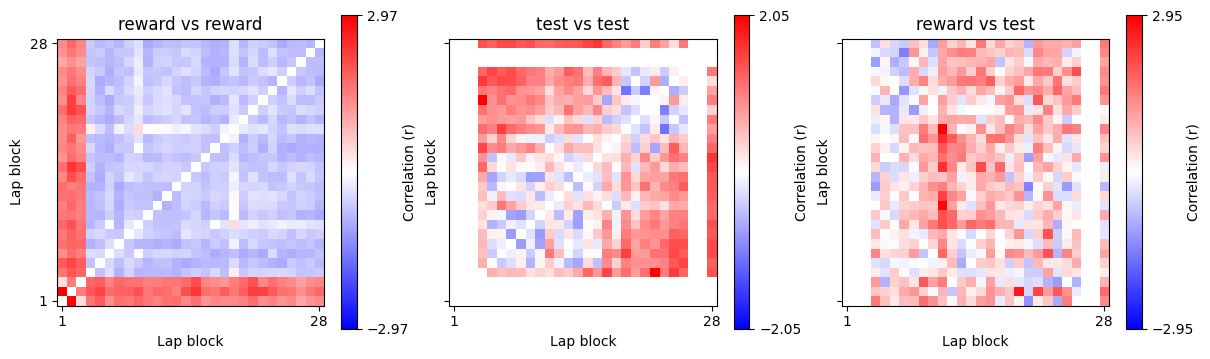

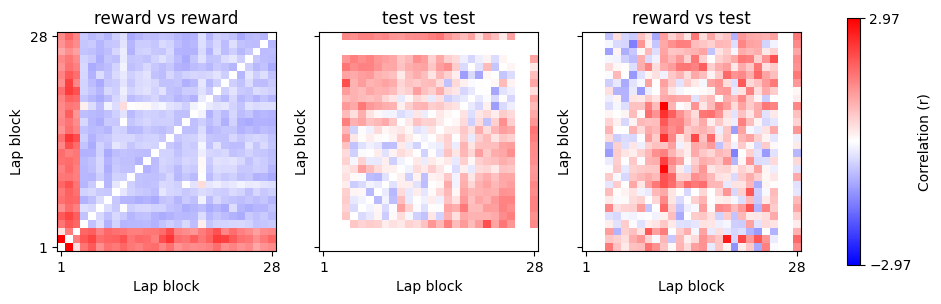

In [ ]:
# Plot the difference
conditions = ['reward', 'test']
condition_pairs = list(itertools.combinations(range(len(conditions)), 2))

fig, ax = plt.subplots(1, len(neural_lick_diff), figsize=(12,4), sharex=True, sharey=True, constrained_layout=True)
ax = ax.ravel()

for i, sim_matrix in enumerate(neural_lick_diff):
    vmax = np.round(np.nanmax(sim_matrix), 2)
    if vmax < 1e-3:
        vmax = 1e-3
    vmin = -vmax
    im = ax[i].imshow(sim_matrix, vmin=vmin, vmax=vmax, cmap='bwr', origin='lower')
    
    cb = fig.colorbar(im, ax=ax[i], shrink=0.8, ticks=[vmin, vmax])  
    cb.set_label('Correlation (r)', labelpad=-5)

    if i < len(conditions):
        ax[i].set_title(f"{conditions[i]} vs {conditions[i]}")
    else:
        ax[i].set_title(f"{conditions[int(condition_pairs[0][0])]} vs {conditions[int(condition_pairs[0][1])]}")
    ax[i].set_xticks([0, sim_matrix.shape[0]-1])
    ax[i].set_xticklabels([1, sim_matrix.shape[0]])
    ax[i].set_yticks([0, sim_matrix.shape[0]-1])
    ax[i].set_yticklabels([1, sim_matrix.shape[0]])
    ax[i].set_xlabel("Lap block")
    ax[i].set_ylabel("Lap block")
# plt.tight_layout()

# Global colormap
all_values = np.concatenate([sim[~np.isnan(sim)].flatten() for sim in neural_lick_diff])
vmax = np.round(np.max(all_values), 2)
vmin = -vmax

fig, ax = plt.subplots(1, len(neural_lick_diff), figsize=(12,4), sharex=True, sharey=True)
ax = ax.ravel()

for i, sim_matrix in enumerate(neural_lick_diff):
    im = ax[i].imshow(sim_matrix, vmin=vmin, vmax=vmax, cmap='bwr', origin='lower')

    if i < len(conditions):
        ax[i].set_title(f"{conditions[i]} vs {conditions[i]}")
    else:
        ax[i].set_title(f"{conditions[int(condition_pairs[0][0])]} vs {conditions[int(condition_pairs[0][1])]}")
    ax[i].set_xticks([0, sim_matrix.shape[0]-1])
    ax[i].set_xticklabels([1, sim_matrix.shape[0]])
    ax[i].set_yticks([0, sim_matrix.shape[0]-1])
    ax[i].set_yticklabels([1, sim_matrix.shape[0]])
    ax[i].set_xlabel("Lap block")
    ax[i].set_ylabel("Lap block")
# plt.tight_layout()
fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.8, label='Correlation (r)', ticks=[vmin, vmax])
